In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from scipy.sparse import csr_matrix

## Classic basic processing

In [2]:
# Load data: converted anndata from seurat obj via celloracle
adata = sc.read('./celloracle/cdk8.19_mouse_seurat_CO_notebook.h5ad')
# In this notebook, I use raw mRNA count as an input of Oracle object.
adata.X = adata.layers["raw_count"].copy()

In [3]:
# mark mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# cosmetical changes
adata.obs['cell_type_condition'] = adata.obs['predicted.CellTypes'].str.cat(adata.obs['condition'], sep="_")

In [4]:
csr_matrix(adata.layers['raw_count'], dtype=np.float32).toarray()[:10, :10]
#checked if there're raw counts. And yep

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 3.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 6.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 5.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 2.]], dtype=float32)

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)

In [6]:
print(adata.shape)
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape)

#Some genes were removed, not cells

(31447, 32285)
(31447, 26193)


In [7]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
#New layer for transformed data
adata.layers["norm_log1p"] = adata.X.copy()

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="orig.ident")

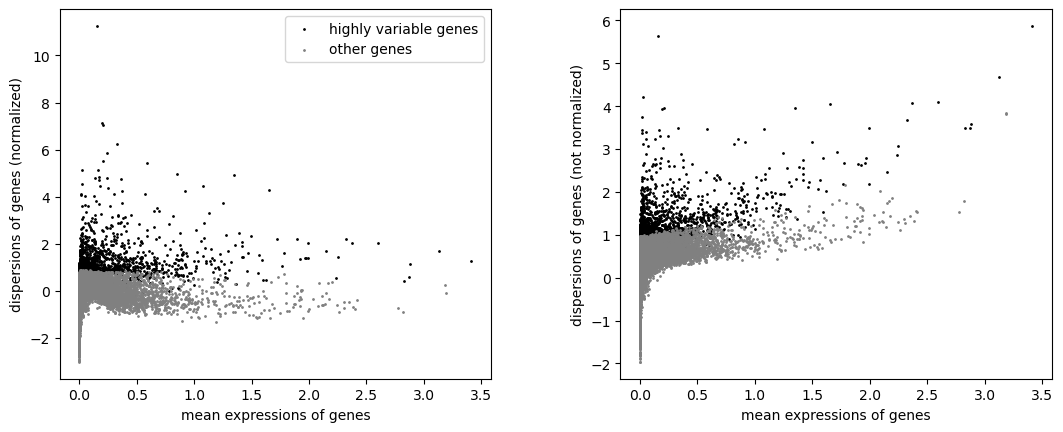

In [9]:
sc.pl.highly_variable_genes(adata)

In [10]:
sc.pp.scale(adata) # z-score
sc.tl.pca(adata)

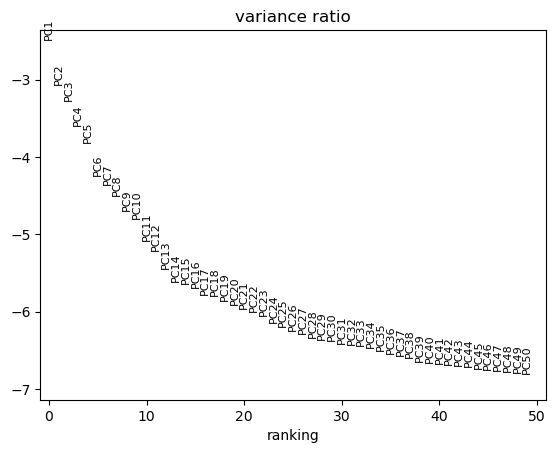

In [11]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

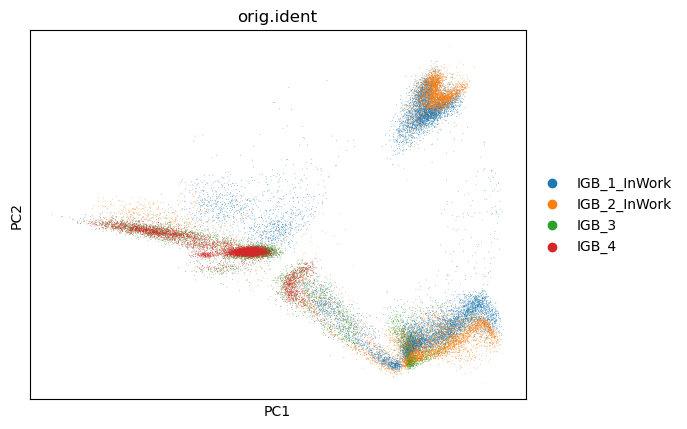

In [12]:
sc.pl.pca(
    adata,
    color=["orig.ident"], #orig.indent - samples feature
    dimensions=[(0, 1)],
    ncols=1,
    size=1,
)

In [13]:
# Run Harmony to correct PCA
sc.external.pp.harmony_integrate(adata, key='orig.ident', max_iter_harmony=20) #correction of batch effect

2025-03-26 10:31:42,861 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-26 10:32:34,366 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-26 10:32:35,027 - harmonypy - INFO - Iteration 1 of 20
2025-03-26 10:33:08,537 - harmonypy - INFO - Iteration 2 of 20
2025-03-26 10:33:41,410 - harmonypy - INFO - Iteration 3 of 20
2025-03-26 10:34:14,639 - harmonypy - INFO - Iteration 4 of 20
2025-03-26 10:34:48,132 - harmonypy - INFO - Iteration 5 of 20
2025-03-26 10:35:16,592 - harmonypy - INFO - Iteration 6 of 20
2025-03-26 10:35:33,002 - harmonypy - INFO - Iteration 7 of 20
2025-03-26 10:35:46,308 - harmonypy - INFO - Iteration 8 of 20
2025-03-26 10:35:59,640 - harmonypy - INFO - Converged after 8 iterations


In [14]:
# Calculate kNN graph
sc.pp.neighbors(adata, n_pcs=40, use_rep='X_pca_harmony')

# Calculate leiden clusters
sc.tl.leiden(adata)

# Calculate UMAP
sc.tl.umap(adata)

/tmp/ipykernel_1964813/403468874.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


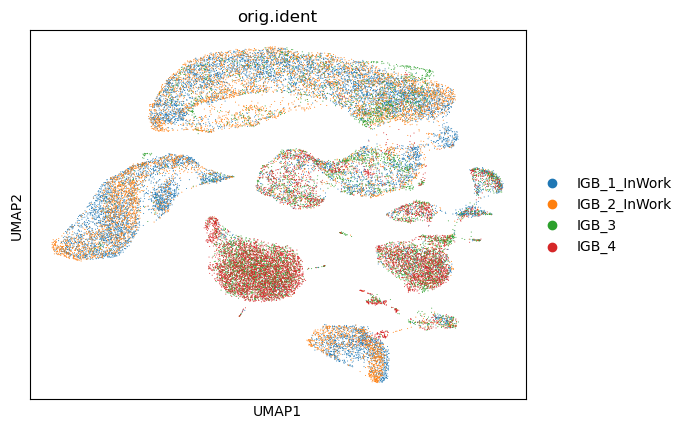

In [15]:
sc.pl.umap(
    adata,
    color="orig.ident",
    size=2,
)

In [16]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

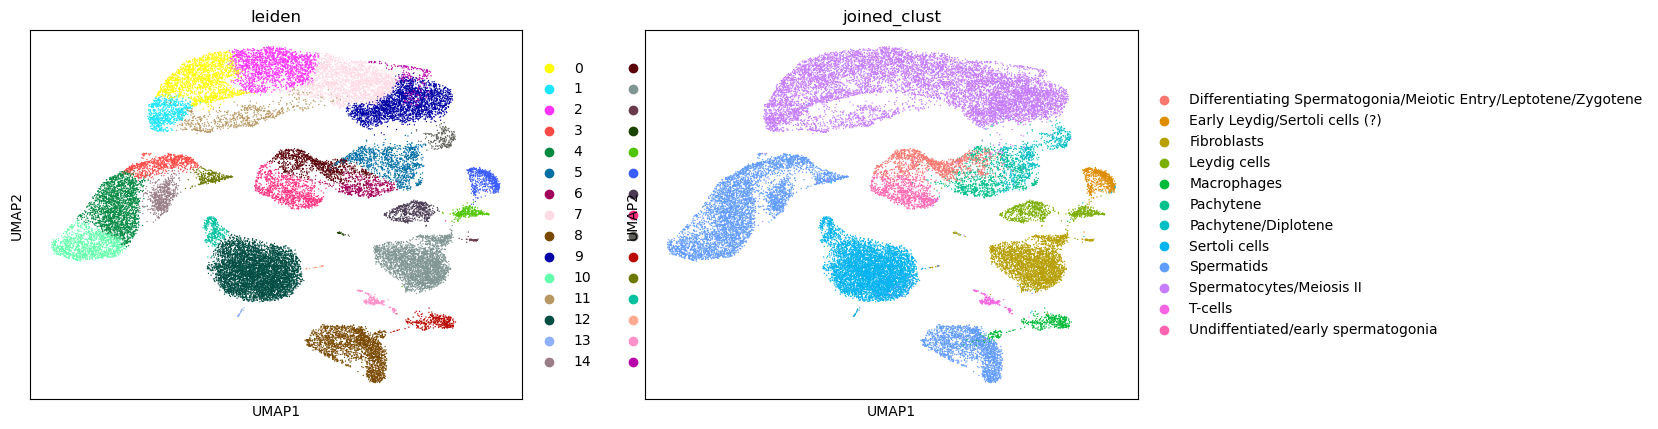

In [17]:
sc.pl.umap(adata, color=["leiden", "joined_clust"])

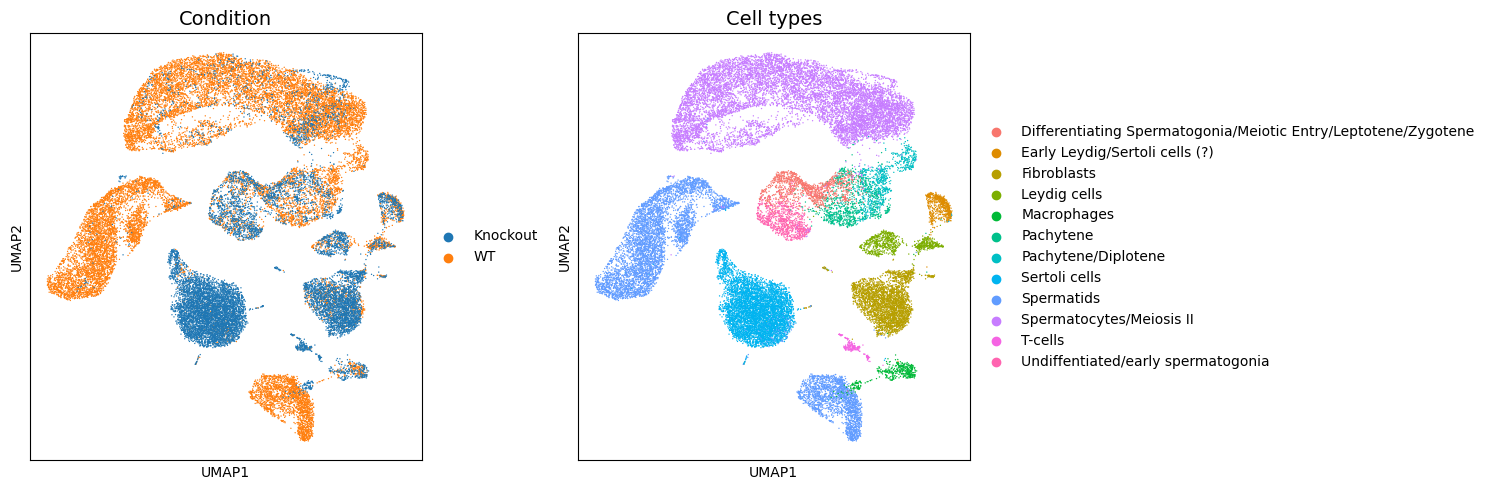

In [18]:
# Ensure Scanpy outputs two separate subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# First UMAP (condition)
sc.pl.umap(adata, color="condition", ax=axes[0], show=False)
axes[0].set_title("Condition", fontsize=14)

# Second UMAP (predicted.CellTypes) with a new title
sc.pl.umap(adata, color="joined_clust", ax=axes[1], show=False)
axes[1].set_title("Cell types", fontsize=14)

plt.tight_layout()
plt.show()

## DE analysis == pseudobulk

In [19]:
import decoupler as dc

# DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [20]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='orig.ident', #== sample
    groups_col='joined_clust', #==cell type
    layer='raw_count',
    mode='sum', #default
    min_cells=10, #filtration
    min_counts=100 #filtration
)

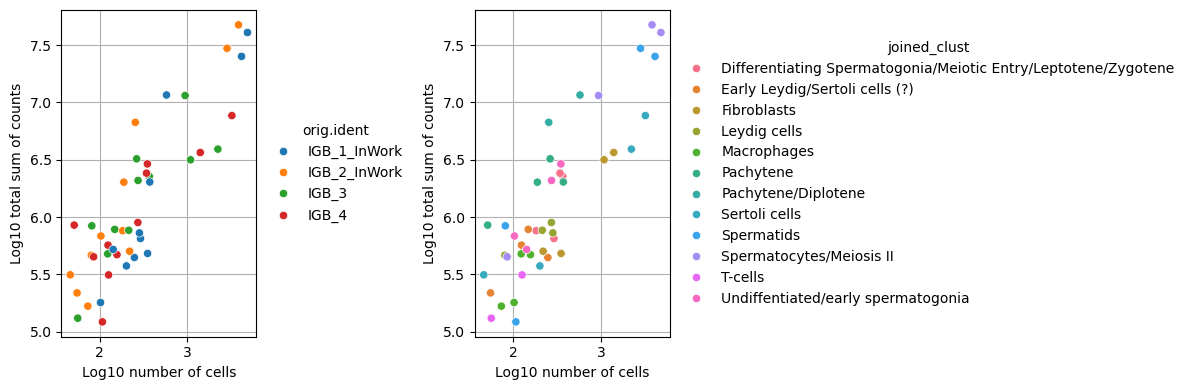

In [21]:
dc.plot_psbulk_samples(pdata, groupby=['orig.ident', 'joined_clust'], figsize=(12, 4))

In [22]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

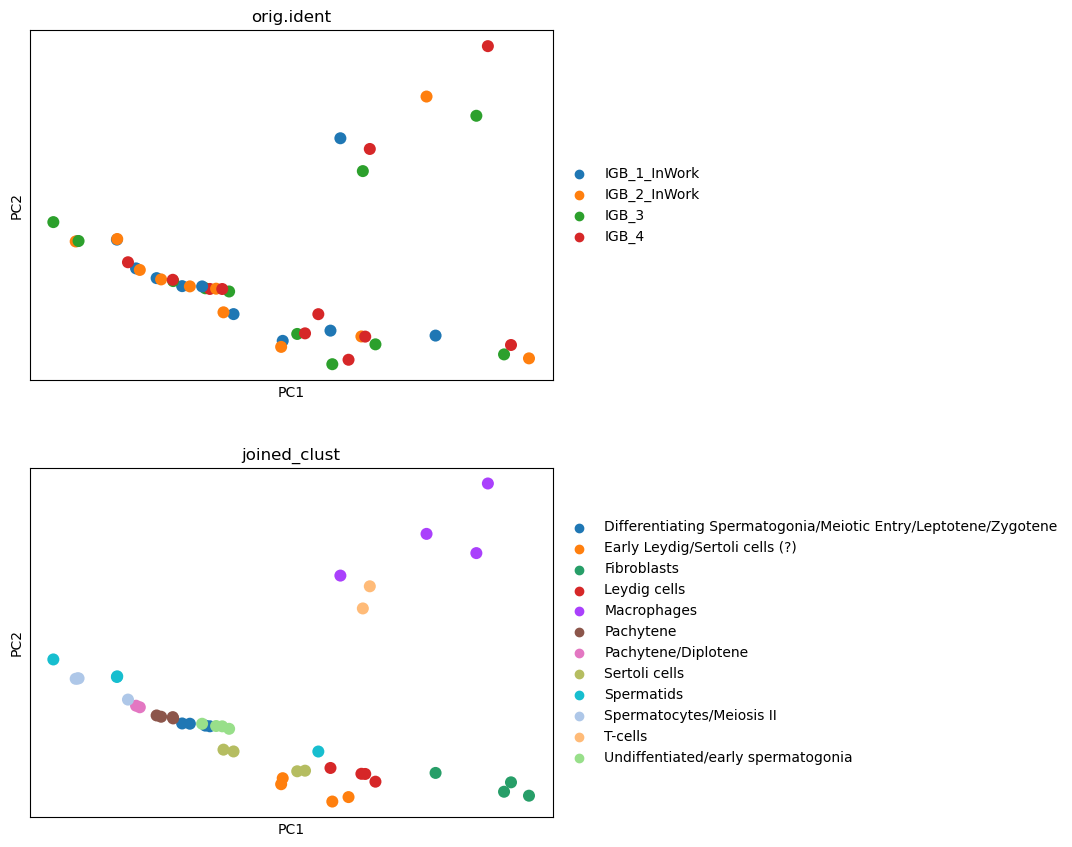

In [23]:
sc.pl.pca(pdata, color=['orig.ident', 'joined_clust'], ncols=1, size=300)
#We see distribution of samples on PCA according to cell types, not samples 

In [29]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['samples', 'condition', 'joined_clust', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

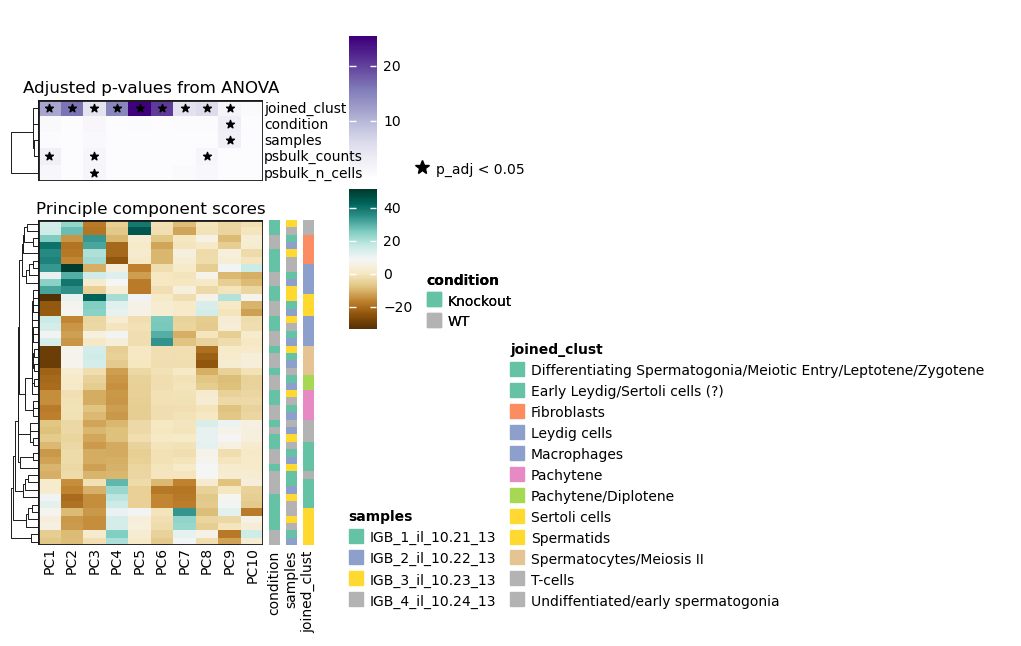

In [30]:
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['condition', 'samples', 'joined_clust'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

#Meaning: PCA separates cell types, not condition

In [31]:
bulk = pd.read_csv('DEGs_from_bulkRNAseq.csv') #for intersection

set(pdata.obs['joined_clust'])

{'Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene',
 'Early Leydig/Sertoli cells (?)',
 'Fibroblasts',
 'Leydig cells',
 'Macrophages',
 'Pachytene',
 'Pachytene/Diplotene',
 'Sertoli cells',
 'Spermatids',
 'Spermatocytes/Meiosis II',
 'T-cells',
 'Undiffentiated/early spermatogonia'}

In [55]:
#Because python doesn't like special symbols
pdata.obs['joined_clust'] = pdata.obs['joined_clust'].astype(str)
pdata.obs.loc[pdata.obs['joined_clust'] == 'Early Leydig/Sertoli cells (?)', 'joined_clust'] = 'Early Leydig_or_Sertoli_maybe'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene', 'joined_clust'] = 'Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Pachytene/Diplotene', 'joined_clust'] = 'Pachytene_or_Diplotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Spermatocytes/Meiosis II', 'joined_clust'] = 'Spermatocytes_or_Meiosis_II'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Undiffentiated/early spermatogonia', 'joined_clust'] = 'Undiffentiated_or_early_spermatogonia'

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 15.98 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 16.06 seconds.

Fitting LFCs...
... done in 7.52 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.02 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       82.900600        0.806289  0.548152  1.470921  1.413125e-01   
1       86.146891       -2.194490  0.548940 -3.997687  6.396433e-05   
2       39.754718        0.160033  0.590705  0.270918  7.864542e-01   
3       52.076190        0.976315  0.534771  1.825669  6.790008e-02   
4      158.361790        0.636711  0.394191  1.615234  1.062600e-01   
...           ...             ...       ...       ...           ...   
7482  5287.824174       -4.961393  0.595798 -8.327310  8.269966e-17   
7483  6732.242549       -1.869295  0.336754 -5.550918  2.841731e-08   
7484  5160.493826       -1.345422  0.552564 -2.434870  1.489713e-02   
7485  2609.865366       -1.637088  0.518363 -3.158186  1.587540e-03   
7486   717.989234       -1.367304  0.645405 -2.118521  3.413099e-02   

              padj  
0     3.302646e-01  
1     6.808984e-04  
2     8.937656e-01  


Fitting MAP LFCs...
... done in 16.78 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       82.900600       -0.648740  0.521797  1.470921  1.413125e-01   
1       86.146891        1.996698  0.555616 -3.997687  6.396433e-05   
2       39.754718       -0.119097  0.534401  0.270918  7.864542e-01   
3       52.076190       -0.808284  0.509518  1.825669  6.790008e-02   
4      158.361790       -0.562739  0.382884  1.615234  1.062600e-01   
...           ...             ...       ...       ...           ...   
7482  5287.824174        4.829284  0.599615 -8.327310  8.269966e-17   
7483  6732.242549        1.793278  0.337670 -5.550918  2.841731e-08   
7484  5160.493826        1.144081  0.548116 -2.434870  1.489713e-02   
7485  2609.865366        1.452511  0.519475 -3.158186  1.587540e-03   
7486   717.989234        1.092833  0.637811 -2.118521  3.413099e-02   

              padj  
0     3.302646e-01  
1     6.808984e-04  
2     8.937656e-01  
3 

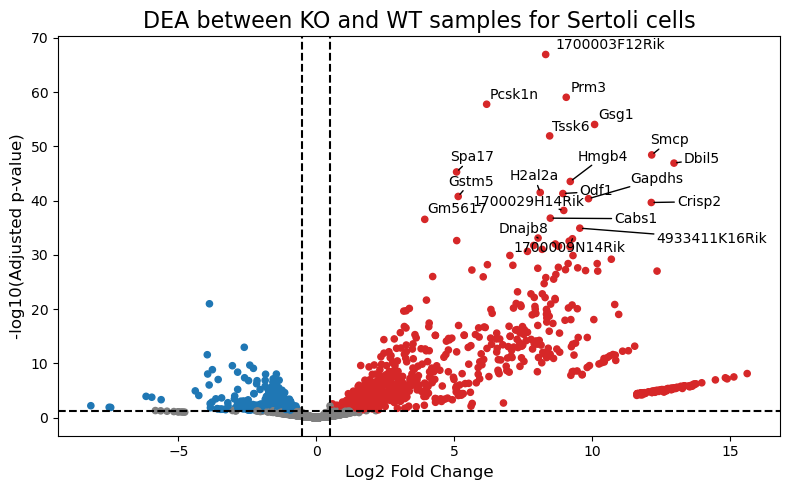

significantly DE genes for  Sertoli cells , intersected with bulk DEGs:
['Rps10', 'Bex2', 'Anxa5', 'Mtch1', 'Wdtc1', 'Sort1', 'Eif4g3', 'Plekho1', 'Flrt1', 'Acss2', 'Gng5', 'Gstm1', 'Plp1', 'Rnf144a', 'Grb14', 'S100a11', 'Spag9', 'Dtd1', 'Myl12a', 'Sh3bgrl3', 'Actg1', 'Fam234b', 'Tulp4', 'Trim36', 'Tiam1', 'Cnn3', 'Mfge8', 'Phgdh', 'Oxct1', 'Paqr7', 'Pias2', 'Qdpr', 'Hk2', 'Ppp2ca', 'Tmx4', 'Knstrn', 'Ndst1', 'Slco3a1', 'Tle5', 'Prr13', 'Msh3', 'Prdx4', 'Mef2c', 'Hdgfl3', 'Vim', 'Laptm4b', 'Colgalt1', 'Fads1', 'Synm', 'Cpeb2', 'Cmip', 'Osbpl9', 'Mir100hg', 'Abcd2', 'Mpst', 'Rapgef6', 'Syap1', 'Atp1b1', 'Myo10', 'Hnrnpa0', 'Rps6', 'Ptprg', 'Kndc1', 'Soat1', 'Ccl27a', 'Ubash3b', 'Sh3bgrl', 'St8sia1', 'Slc30a4', 'Ptprd', 'Tpm1', 'Ldha', 'Rps2', 'Got1', 'Id2', 'H3f3b', 'Ppp1r9a', '6430548M08Rik', 'Prkar1a', 'Ostf1', 'Mcm7', 'Vrk1', 'Cyth1', 'Tmsb4x', 'Gamt', 'Dynlt1b', 'Ndufc2', 'Gja1', 'Rpl12', 'Aup1', 'Slc45a4', 'Rgcc', 'Cyb5r1', 'Jcad', 'Plcb1', 'Pdlim4', 'Prkce', 'Atp1a1', 'Tcfl5', 'An

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 28.54 seconds.

Fitting dispersion trend curve...
... done in 0.60 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 26.68 seconds.

Fitting LFCs...
... done in 19.43 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.94 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
          baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0       911.712125        0.010461  0.557129  0.018776  9.850197e-01  0.999878
1       181.511215        0.441822  0.733002  0.602757  5.466704e-01  0.999878
2      3687.800823        0.407184  0.515173  0.790383  4.293041e-01  0.999878
3       624.248805       -0.084133  0.596401 -0.141068  8.878161e-01  0.999878
4       130.727215        2.290701  0.985192  2.325131  2.006493e-02  0.999878
...            ...             ...       ...       ...           ...       ...
13249  1055.626863       -3.024108  0.616991 -4.901383  9.516444e-07  0.003153
13250  3325.042514       -0.083094  0.548719 -0.151432  8.796348e-01  0.999878
13251  2200.187604        0.227917  0.532780  0.427789  6.688049e-01  0.999878
13252   975.211274       -0.313094  0.614284 -0.509689  6.102691e-01  0.999878
13253   206.069233       -0.508410  0.823340 -0.617497  5.369067e-01

Fitting MAP LFCs...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
... done in 71.05 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
          baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0       911.712125    3.279788e-08  0.001465  0.018776  9.850197e-01  0.999878
1       181.511215   -8.009262e-07  0.001408  0.602757  5.466704e-01  0.999878
2      3687.800823   -1.610007e-06  0.001358  0.790383  4.293041e-01  0.999878
3       624.248805    2.489623e-07  0.001496 -0.141068  8.878161e-01  0.999878
4       130.727215   -2.035611e-06  0.001167  2.325131  2.006493e-02  0.999878
...            ...             ...       ...       ...           ...       ...
13249  1055.626863    2.740374e+00  0.642812 -4.901383  9.516444e-07  0.003153
13250  3325.042514    6.654039e-07  0.001473 -0.151432  8.796348e-01  0.999878
13251  2200.187604   -8.211426e-07  0.001402  0.427789  6.688049e-01  0.999878
13252   975.211274    9.251972e-07  0.001556 -0.509689  6.102691e-01  0.999878
13253   206.069233    7.536154e-07  0.001667 -0.617497  5.369067e-01  

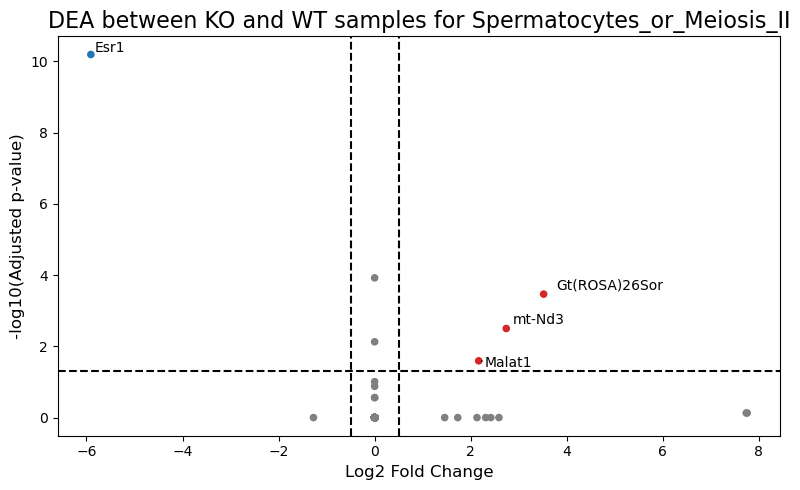

significantly DE genes for  Spermatocytes_or_Meiosis_II , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 15.52 seconds.

Fitting dispersion trend curve...
... done in 0.38 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 16.23 seconds.

Fitting LFCs...
... done in 6.32 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Fitting size factors...
... done in 0.00 seconds.



There is no KO or WT samples for this cell type
Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 6.43 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.14 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 6.72 seconds.

Fitting LFCs...
... done in 3.43 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.02 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0       36.132613        0.034975  0.672879  0.051979  9.585457e-01  0.997895
1       55.529800       -9.959518  2.485782 -4.006594  6.160067e-05  0.001648
2       33.103220       -9.216684  2.474779 -3.724245  1.959008e-04  0.004112
3       27.860044        0.478209  0.685005  0.698110  4.851087e-01  0.994501
4       68.754287      -10.265821  2.480754 -4.138185  3.500636e-05  0.001040
...           ...             ...       ...       ...           ...       ...
3500  2509.977715       -3.628366  0.680212 -5.334169  9.598332e-08  0.000010
3501  4167.409581       -0.375171  0.625346 -0.599941  5.485453e-01  0.994501
3502  3923.500647       -0.095132  0.704600 -0.135015  8.925999e-01  0.996291
3503  2009.072441       -0.562737  0.677619 -0.830463  4.062772e-01  0.969368
3504   807.209780       -0.328951  0.727398 -0.452229  6.511037e-01  0.994501



... done in 8.16 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0       36.132613       -0.011611  0.477473  0.051979  9.585457e-01  0.997895
1       55.529800       10.190767  2.783961 -4.006594  6.160067e-05  0.001648
2       33.103220        9.330070  2.670110 -3.724245  1.959008e-04  0.004112
3       27.860044       -0.170441  0.491879  0.698110  4.851087e-01  0.994501
4       68.754287       10.553072  2.821332 -4.138185  3.500636e-05  0.001040
...           ...             ...       ...       ...           ...       ...
3500  2509.977715        3.369760  0.693807 -5.334169  9.598332e-08  0.000010
3501  4167.409581        0.151050  0.489311 -0.599941  5.485453e-01  0.994501
3502  3923.500647        0.033830  0.500680 -0.135015  8.925999e-01  0.996291
3503  2009.072441        0.209169  0.533004 -0.830463  4.062772e-01  0.969368
3504   807.209780        0.107978  0.524716 -0.452229  6.511037e-01  0.994501

[3

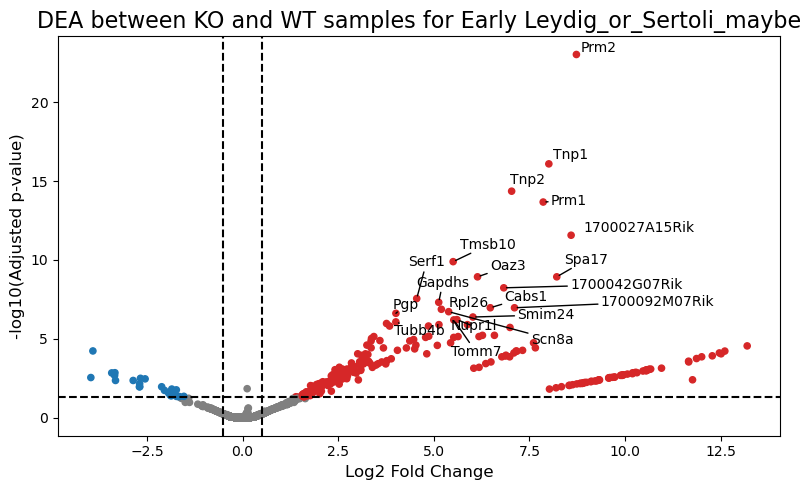

significantly DE genes for  Early Leydig_or_Sertoli_maybe , intersected with bulk DEGs:
['Rpl6', 'Gpi1', 'Mt2', 'Rai1', 'Rpl41', 'Sub1', 'Tmsb10', 'Tet3', 'Chd7', 'Calm3', 'Rps24', 'Rps15', 'Gm10076', 'Cst3', 'Notch1', 'Thra', 'Mt1', 'Ccl27a', 'Dynll2', 'Atp1a2', 'Gabarap', 'Rpl35', 'Alcam', 'Ssr4', 'Dab1']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 11.53 seconds.

Fitting dispersion trend curve...
... done in 0.33 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 13.03 seconds.

Fitting LFCs...
... done in 6.32 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.11 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       45.945018        0.332815  0.552183  0.602727  5.466906e-01   
1       55.622668       -1.724244  0.614145 -2.807552  4.991962e-03   
2       56.165923        0.013548  0.503821  0.026890  9.785471e-01   
3       82.061415        0.443994  0.449836  0.987014  3.236359e-01   
4       49.745833       -0.596755  0.514357 -1.160196  2.459690e-01   
...           ...             ...       ...       ...           ...   
6634  2261.711466       -2.377090  0.316346 -7.514218  5.725197e-14   
6635  4999.163124        0.056336  0.257502  0.218778  8.268228e-01   
6636  3557.159570        0.441680  0.257871  1.712790  8.675113e-02   
6637  1670.411632        0.162767  0.258083  0.630677  5.282518e-01   
6638   284.844758       -0.085341  0.364297 -0.234261  8.147820e-01   

              padj  
0     9.987696e-01  
1     1.086611e-01  
2     9.987696e-01  


... done in 16.55 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       45.945018       -0.045615  0.259766  0.602727  5.466906e-01   
1       55.622668        1.060904  0.710481 -2.807552  4.991962e-03   
2       56.165923       -0.001907  0.254516  0.026890  9.785471e-01   
3       82.061415       -0.089693  0.261685  0.987014  3.236359e-01   
4       49.745833        0.098251  0.300377 -1.160196  2.459690e-01   
...           ...             ...       ...       ...           ...   
6634  2261.711466        2.292681  0.319192 -7.514218  5.725197e-14   
6635  4999.163124       -0.023175  0.197706  0.218778  8.268228e-01   
6636  3557.159570       -0.233078  0.243013  1.712790  8.675113e-02   
6637  1670.411632       -0.069422  0.202275  0.630677  5.282518e-01   
6638   284.844758        0.022876  0.235623 -0.234261  8.147820e-01   

              padj  
0     9.987696e-01  
1     1.086611e-01  
2     9.987696e-01  
3 

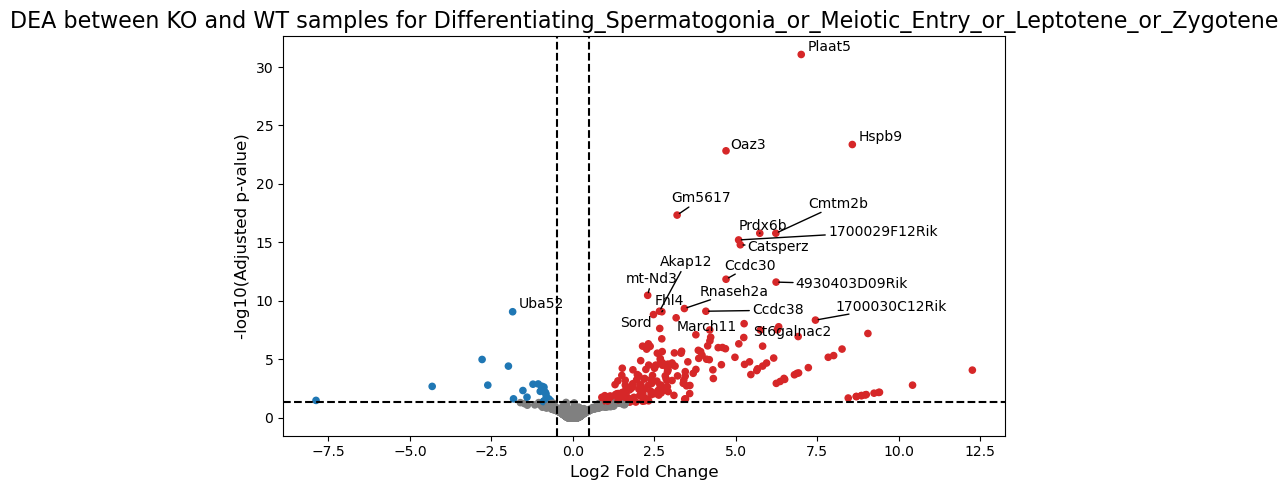

significantly DE genes for  Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene , intersected with bulk DEGs:
['Rps10', 'Osbp2', 'Wdtc1', 'Akap12', 'Ccl27a', 'Rpl23', 'Camk2n1', 'Tpi1', 'Rpl36a']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 6.23 seconds.

Fitting dispersion trend curve...
... done in 0.21 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 7.66 seconds.

Fitting LFCs...
... done in 3.07 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.20 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       29.710019        0.151208  0.537993  0.281059  7.786654e-01   
1       61.794996       -0.138751  0.451033 -0.307629  7.583645e-01   
2      112.128065       -0.467048  0.408600 -1.143044  2.530204e-01   
3      571.937062       -0.865370  0.413738 -2.091590  3.647525e-02   
4       35.300600       -0.681185  0.524594 -1.298500  1.941154e-01   
...           ...             ...       ...       ...           ...   
3838  2460.181737       -3.699373  0.447640 -8.264178  1.406606e-16   
3839  5885.718107       -1.170525  0.363599 -3.219277  1.285142e-03   
3840  4607.729996       -0.928230  0.424591 -2.186174  2.880291e-02   
3841  3179.062810       -0.998235  0.408955 -2.440942  1.464901e-02   
3842   650.957009       -1.073263  1.145921 -0.936595  3.489672e-01   

              padj  
0     9.681046e-01  
1     9.675234e-01  
2     7.870007e-01  


... done in 9.54 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       29.710019       -0.042094  0.348675  0.281059  7.786654e-01   
1       61.794996        0.050060  0.328018 -0.307629  7.583645e-01   
2      112.128065        0.208173  0.346427 -1.143044  2.530204e-01   
3      571.937062        0.503714  0.420965 -2.091590  3.647525e-02   
4       35.300600        0.228077  0.419962 -1.298500  1.941154e-01   
...           ...             ...       ...       ...           ...   
3838  2460.181737        3.590833  0.451156 -8.264178  1.406606e-16   
3839  5885.718107        0.949759  0.377080 -3.219277  1.285142e-03   
3840  4607.729996        0.545613  0.438027 -2.186174  2.880291e-02   
3841  3179.062810        0.665254  0.427630 -2.440942  1.464901e-02   
3842   650.957009        0.085446  0.542584 -0.936595  3.489672e-01   

              padj  
0     9.681046e-01  
1     9.675234e-01  
2     7.870007e-01  
3 

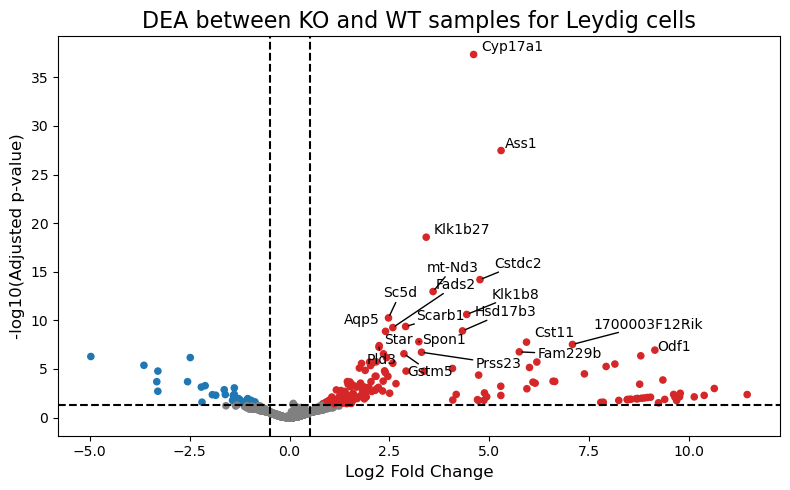

significantly DE genes for  Leydig cells , intersected with bulk DEGs:
['Cav1', 'Abca1', 'Ccnd2', 'Inf2', 'Eif4g3', 'Fads1', 'Plp1', 'Igfbp2', 'Ptn', 'Htra1', 'Lhcgr', 'Gpx1', 'Glul', 'Lmo4', 'Ass1', 'Cst3', 'Mtss2', 'Spon1', 'Akap12', 'Ccl27a', 'Gng12', 'Tst', 'Fads2', 'Id1', 'Csrp2']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.94 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.04 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.45 seconds.

Fitting LFCs...
... done in 0.59 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Fitting size factors...
... done in 0.00 seconds.



There is no KO or WT samples for this cell type
Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 18.68 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.38 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 15.71 seconds.

Fitting LFCs...
... done in 14.17 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.48 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
        baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     102.698976       -0.451244  1.212465 -0.372171  0.709766  0.860322
1     686.833116       -2.161565  1.639386 -1.318521  0.187329  0.559020
2      28.205880        1.542894  1.450733  1.063527  0.287543  0.605879
3     336.903029       -1.570275  1.204265 -1.303928  0.192258  0.560128
4      10.282715        1.782229  1.481751  1.202786  0.229059       NaN
...          ...             ...       ...       ...       ...       ...
7803  576.405077       -3.848236  1.249317 -3.080272  0.002068  0.083874
7804  953.156539       -0.468130  1.252413 -0.373782  0.708566  0.859968
7805  867.181498       -0.568901  1.234193 -0.460950  0.644834  0.822953
7806  440.479880       -0.753961  1.249711 -0.603308  0.546304  0.767825
7807  148.612653       -1.268994  1.337474 -0.948799  0.342723  0.637421

[7808 rows x 6 columns]


... done in 22.54 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
        baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     102.698976        0.157919  0.902944 -0.372171  0.709766  0.860322
1     686.833116        0.505514  1.458320 -1.318521  0.187329  0.559020
2      28.205880       -0.424144  0.992649  1.063527  0.287543  0.605879
3     336.903029        0.610331  1.090522 -1.303928  0.192258  0.560128
4      10.282715       -0.472700  1.070539  1.202786  0.229059       NaN
...          ...             ...       ...       ...       ...       ...
7803  576.405077        2.936999  1.355737 -3.080272  0.002068  0.083874
7804  953.156539        0.158764  0.914409 -0.373782  0.708566  0.859968
7805  867.181498        0.196199  0.919262 -0.460950  0.644834  0.822953
7806  440.479880        0.255707  0.951568 -0.603308  0.546304  0.767825
7807  148.612653        0.399715  1.082623 -0.948799  0.342723  0.637421

[7808 rows x 6 columns]


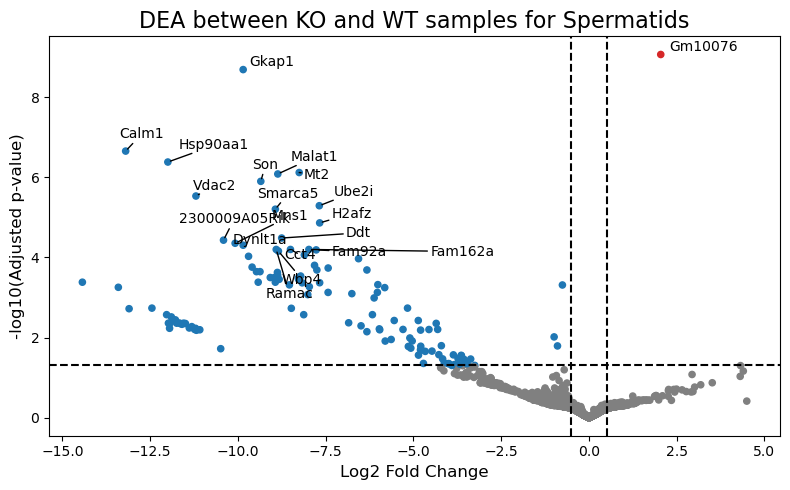

significantly DE genes for  Spermatids , intersected with bulk DEGs:
['Actg1', 'Hsp90aa1', 'Prdx5', 'Arl6ip1', 'Anxa5', 'Dnaja1', 'Cetn3', 'Dynlt1b', 'Ctr9', 'Gm10076', 'Mt2', 'Npm1', 'Tomm20']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.71 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.07 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 3.76 seconds.

Fitting LFCs...
... done in 1.54 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.67 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
        baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0      36.708593       -0.034786  0.706176 -0.049260  9.607124e-01   
1      38.999882       -0.747963  0.751940 -0.994710  3.198772e-01   
2      28.897888       -2.630043  0.781849 -3.363876  7.685595e-04   
3      35.607071       -9.449165  2.512496 -3.760867  1.693253e-04   
4      83.984358       -5.627224  0.849004 -6.628026  3.402048e-11   
...          ...             ...       ...       ...           ...   
1753  404.663230       -3.188950  0.711226 -4.483738  7.334676e-06   
1754  846.733286       -0.527486  0.695038 -0.758932  4.478935e-01   
1755  610.049296       -0.591221  0.692907 -0.853247  3.935222e-01   
1756  415.608209       -0.588195  0.695303 -0.845956  3.975775e-01   
1757   66.824588       -0.839110  0.725437 -1.156697  2.473963e-01   

              padj  
0     9.992008e-01  
1     9.992008e-01  
2     1.437370e-02  
3     4.1343

... done in 4.34 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
        baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0      36.708593        0.009357  0.440032 -0.049260  9.607124e-01   
1      38.999882        0.183311  0.522556 -0.994710  3.198772e-01   
2      28.897888        2.084727  0.828726 -3.363876  7.685595e-04   
3      35.607071        9.548574  2.718856 -3.760867  1.693253e-04   
4      83.984358        5.364103  0.854398 -6.628026  3.402048e-11   
...          ...             ...       ...       ...           ...   
1753  404.663230        2.850578  0.733723 -4.483738  7.334676e-06   
1754  846.733286        0.142889  0.487784 -0.758932  4.478935e-01   
1755  610.049296        0.162476  0.496041 -0.853247  3.935222e-01   
1756  415.608209        0.160506  0.495796 -0.845956  3.975775e-01   
1757   66.824588        0.223807  0.539871 -1.156697  2.473963e-01   

              padj  
0     9.992008e-01  
1     9.992008e-01  
2     1.437370e-02  
3     4.134360

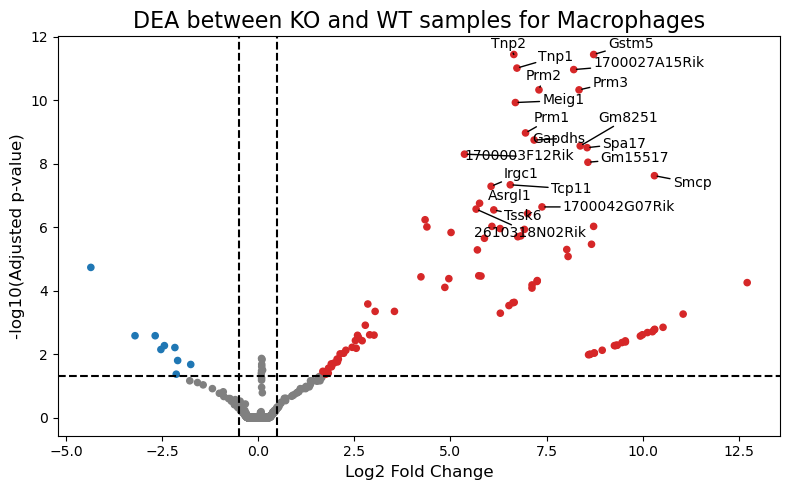

significantly DE genes for  Macrophages , intersected with bulk DEGs:
['Osbp2', 'Lpl', 'Chd5', 'Ccl27a', 'S100a11', 'Dynll2']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 12.79 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 14.07 seconds.

Fitting LFCs...
... done in 6.62 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.33 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       30.967614        1.018678  0.672110  1.515641  1.296102e-01   
1       56.352374        0.255028  0.500349  0.509699  6.102621e-01   
2       95.547420        0.081328  0.426182  0.190829  8.486596e-01   
3       52.355638        0.145078  0.504603  0.287509  7.737223e-01   
4      212.235600       -0.633577  0.370825 -1.708563  8.753191e-02   
...           ...             ...       ...       ...           ...   
7504  1500.865209       -2.786308  0.382756 -7.279603  3.348033e-13   
7505  3595.148092       -0.154736  0.308366 -0.501793  6.158129e-01   
7506  2650.214162        0.078729  0.346083  0.227487  8.200452e-01   
7507  1706.530854        0.098386  0.327878  0.300070  7.641236e-01   
7508   301.832546       -0.197749  0.383097 -0.516185  6.057249e-01   

              padj  
0     6.280672e-01  
1     9.697730e-01  
2     9.928085e-01  


... done in 17.43 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       30.967614       -0.290357  0.484968  1.515641  1.296102e-01   
1       56.352374       -0.091059  0.351937  0.509699  6.102621e-01   
2       95.547420       -0.034393  0.321433  0.190829  8.486596e-01   
3       52.355638       -0.050155  0.348699  0.287509  7.737223e-01   
4      212.235600        0.381609  0.355225 -1.708563  8.753191e-02   
...           ...             ...       ...       ...           ...   
7504  1500.865209        2.683760  0.386324 -7.279603  3.348033e-13   
7505  3595.148092        0.092900  0.268969 -0.501793  6.158129e-01   
7506  2650.214162       -0.041044  0.288104  0.227487  8.200452e-01   
7507  1706.530854       -0.054374  0.277625  0.300070  7.641236e-01   
7508   301.832546        0.097072  0.313412 -0.516185  6.057249e-01   

              padj  
0     6.280672e-01  
1     9.697730e-01  
2     9.928085e-01  
3 

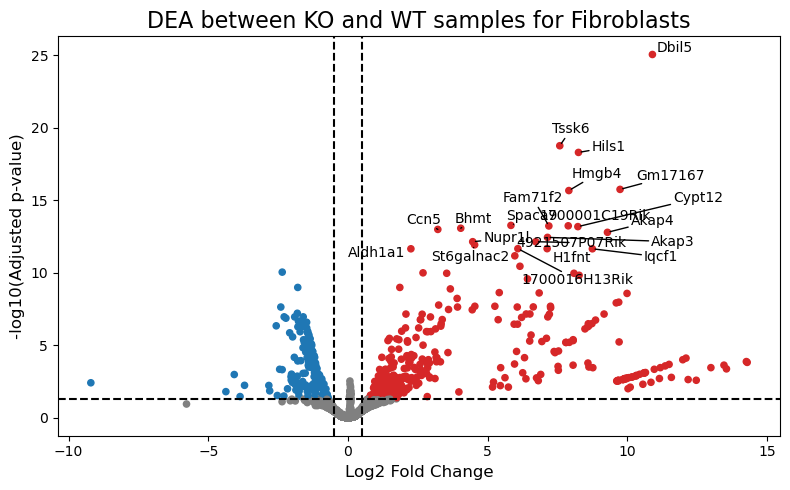

significantly DE genes for  Fibroblasts , intersected with bulk DEGs:
['Rps10', 'Flrt2', 'Syt1', 'Osbp2', 'Map2', 'Tent5a', 'Vim', 'Papss2', 'Gpi1', 'Dynlt1b', 'Cx3cl1', 'Rpl12', 'Npy', 'Rpl10a', 'Cyp26b1', 'Adamts1', 'Nr2f2', 'Oxtr', 'Nrn1', 'Rps24', 'Rps15', '5031439G07Rik', 'Nabp1', 'Rpl10', 'Glul', 'Cxcl12', 'Ndrg2', 'Rpl4', 'Rpl23', 'Cyp1b1', 'Cst3', 'Mtss2', 'Idh1', 'Mapk6', 'Rps6', 'Spon1', 'Trim36', 'Itga9', 'Akap12', 'Rps3a1', 'Anxa6', 'Bambi', 'Dynll2', 'Id3', 'Ube2k', 'Fcgr2b', 'Rpl36a', 'Ccn2', 'Spag4', 'Rpl7a', 'Ppfibp1', 'Rps2', 'Actr3b', 'Chd5', 'Fn1', 'Id2', 'Rps4x', 'Rpl35', 'Cdh11', 'Fbn1', 'Id1', 'Rack1']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 12.09 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 13.63 seconds.

Fitting LFCs...
... done in 6.20 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.20 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       89.329729        0.025417  0.386472  0.065767  9.475633e-01   
1      347.546316       -0.484979  0.354978 -1.366222  1.718692e-01   
2      103.432032       -0.012090  0.371070 -0.032581  9.740087e-01   
3       46.472989        0.979446  0.512077  1.912692  5.578743e-02   
4      121.744564       -0.512944  0.359365 -1.427361  1.534758e-01   
...           ...             ...       ...       ...           ...   
6877  1789.617576       -2.574254  0.280758 -9.168950  4.776471e-20   
6878  3999.725962        0.023441  0.219805  0.106646  9.150695e-01   
6879  2928.514828        0.359312  0.231879  1.549565  1.212459e-01   
6880  1313.401695        0.088116  0.234092  0.376417  7.066071e-01   
6881   253.285731        0.088803  0.379534  0.233980  8.150006e-01   

              padj  
0     9.989256e-01  
1     9.447314e-01  
2     9.989256e-01  


... done in 19.95 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       89.329729       -0.003077  0.185094  0.065767  9.475633e-01   
1      347.546316        0.080372  0.219854 -1.366222  1.718692e-01   
2      103.432032        0.001785  0.183421 -0.032581  9.740087e-01   
3       46.472989       -0.084323  0.218621  1.912692  5.578743e-02   
4      121.744564        0.084127  0.224457 -1.427361  1.534758e-01   
...           ...             ...       ...       ...           ...   
6877  1789.617576        2.513403  0.281780 -9.168950  4.776471e-20   
6878  3999.725962       -0.006975  0.151162  0.106646  9.150695e-01   
6879  2928.514828       -0.128073  0.193825  1.549565  1.212459e-01   
6880  1313.401695       -0.025068  0.156825  0.376417  7.066071e-01   
6881   253.285731       -0.011460  0.182354  0.233980  8.150006e-01   

              padj  
0     9.989256e-01  
1     9.447314e-01  
2     9.989256e-01  
3 

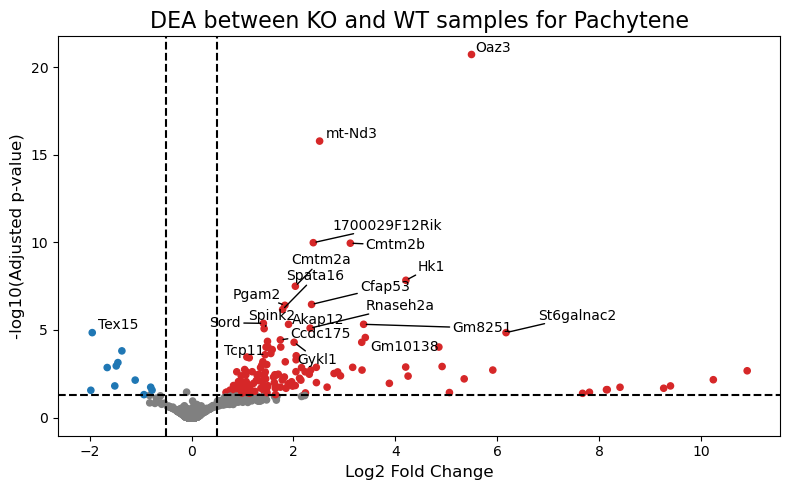

significantly DE genes for  Pachytene , intersected with bulk DEGs:
['Osbp2', 'Akap12', 'Dynlt1b', 'Ccl27a', 'Camk2n1', 'Spock2']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 11.55 seconds.

Fitting dispersion trend curve...
... done in 0.35 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 12.54 seconds.

Fitting LFCs...
... done in 6.16 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.21 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       41.400305        0.118865  0.535033  0.222164  8.241859e-01   
1       38.328923       -1.962446  0.665777 -2.947604  3.202468e-03   
2       35.680693       -0.181281  0.551392 -0.328771  7.423290e-01   
3      183.463773        0.418043  0.319941  1.306623  1.913408e-01   
4       98.257589       -0.493581  0.399244 -1.236290  2.163507e-01   
...           ...             ...       ...       ...           ...   
6707  1688.067919       -2.418617  0.313328 -7.719115  1.171401e-14   
6708  3614.313907        0.002939  0.250037  0.011753  9.906225e-01   
6709  2533.809497        0.393615  0.276218  1.425016  1.541526e-01   
6710  1203.301739        0.202401  0.267605  0.756341  4.494448e-01   
6711   182.759044       -0.068124  0.372836 -0.182718  8.550191e-01   

              padj  
0     9.992867e-01  
1     8.956235e-02  
2     9.992867e-01  


... done in 14.19 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       41.400305       -0.014186  0.233805  0.222164  8.241859e-01   
1       38.328923        1.299668  0.759451 -2.947604  3.202468e-03   
2       35.680693        0.020838  0.241043 -0.328771  7.423290e-01   
3      183.463773       -0.133021  0.239118  1.306623  1.913408e-01   
4       98.257589        0.108031  0.264590 -1.236290  2.163507e-01   
...           ...             ...       ...       ...           ...   
6707  1688.067919        2.336206  0.316221 -7.719115  1.171401e-14   
6708  3614.313907       -0.000637  0.185922  0.011753  9.906225e-01   
6709  2533.809497       -0.157951  0.232641  1.425016  1.541526e-01   
6710  1203.301739       -0.074308  0.200072  0.756341  4.494448e-01   
6711   182.759044        0.015127  0.220816 -0.182718  8.550191e-01   

              padj  
0     9.992867e-01  
1     8.956235e-02  
2     9.992867e-01  
3 

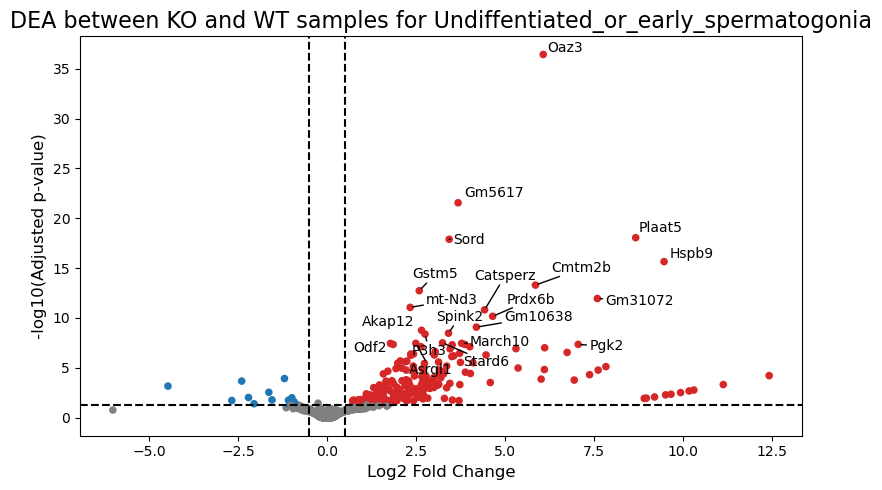

significantly DE genes for  Undiffentiated_or_early_spermatogonia , intersected with bulk DEGs:
['Mapk6', 'Ldha', 'Osbp2', 'Akap12', 'Ccl27a', 'Dzip1', 'Glul', 'Tpi1', 'Srpk2']


In [56]:
for i in set(pdata.obs['joined_clust']):
    cell_type = pdata[pdata.obs['joined_clust'] == i].copy()
    genes = dc.filter_by_expr(cell_type, group='condition', min_count=30, min_total_count=40)

    # Filter by these genes
    cell_type = cell_type[:, genes].copy()
    # Build DESeq2 object
    inference = DefaultInference(n_cpus=1)
    dds = DeseqDataSet(
        counts=cell_type.X,
        metadata=cell_type.obs,
        design='~condition',
        refit_cooks=True,
        inference=inference,
    )
    # Compute LFCs
    dds.deseq2()

    if 'Knockout' not in set(dds.obs['condition']) or 'WT' not in set(dds.obs['condition']):
        print('There is no KO or WT samples for this cell type')
        continue
    
    # Extract contrast between KO and WT
    ds_KO_vs_WT = DeseqStats(
        dds,
        contrast=["condition", 'Knockout', 'WT'],
        inference=inference,
    )
    # Compute Wald test
    ds_KO_vs_WT.summary()
    ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")
    results_df = ds_KO_vs_WT.results_df
    results_df.index = cell_type.var.index

    dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=20,
        figsize=(8, 5)
    )

    title = 'DEA between KO and WT samples for ' + i
    plt.title(title, fontsize=16)
    plt.xlabel('Log2 Fold Change', fontsize=12)
    plt.ylabel('-log10(Adjusted p-value)', fontsize=12)
    
    plt.tight_layout()
    path = f'./pseudobulk_DEGs/all_stages_{i}.png'
    plt.savefig(path, dpi=300)
    plt.show()

    
    significant = results_df[abs(results_df['padj']) < 0.05]
    singlecell = significant.index
    sc_bulk_intersection = list(set(singlecell) & set(bulk['x']))

    print('significantly DE genes for ', i, ', intersected with bulk DEGs:')
    print(sc_bulk_intersection)
    
    dict_to_save = {i: sc_bulk_intersection}
    df = pd.DataFrame(dict_to_save)
    path = './pseudobulk_DEGs/sc_bulk_intersected_DEGs_for_all_stages_'+i+'.csv'
    df.to_csv(path, index=False)

    dict_to_save = {i: singlecell}
    df = pd.DataFrame(dict_to_save)
    path = './pseudobulk_DEGs/sc_DEGs_for_all_stages_'+i+'.csv'
    df.to_csv(path, index=False)

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 20.77 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 25.86 seconds.

Fitting LFCs...
... done in 12.08 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 647 outlier genes.

Fitting dispersions...
... done in 1.85 seconds.

Fitting MAP dispersions...
... done in 2.07 seconds.

Fitting LFCs...
... done in 1.46 seconds.

Running Wald tests...
... done in 2.49 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       57.435539       -0.286317  0.412966 -0.693320  4.881088e-01   
1      233.124329       -1.592126  0.659157 -2.415399  1.571800e-02   
2       43.536462       -0.288953  0.341998 -0.844896  3.981692e-01   
3       44.668929        0.625197  0.385011  1.623842  1.044094e-01   
4      144.717445       -0.766532  0.366822 -2.089654  3.664888e-02   
...           ...             ...       ...       ...           ...   
7492  2001.934872       -3.295267  0.374576 -8.797330  1.401098e-18   
7493  3976.173110       -0.497620  0.350358 -1.420321  1.555143e-01   
7494  3155.017529       -0.209704  0.383127 -0.547350  5.841384e-01   
7495  1804.323953       -0.420177  0.401081 -1.047611  2.948180e-01   
7496   451.721731       -0.400363  0.475392 -0.842174  3.996903e-01   

              padj  
0     7.907195e-01  
1     1.810519e-01  
2     7.375062e-01  


... done in 23.86 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       57.435539        0.079407  0.284739 -0.693320  4.881088e-01   
1      233.124329        0.292020  0.645688 -2.415399  1.571800e-02   
2       43.536462        0.106241  0.263611 -0.844896  3.981692e-01   
3       44.668929       -0.231176  0.330494  1.623842  1.044094e-01   
4      144.717445        0.384474  0.377412 -2.089654  3.664888e-02   
...           ...             ...       ...       ...           ...   
7492  2001.934872        3.210333  0.377009 -8.797330  1.401098e-18   
7493  3976.173110        0.200741  0.303548 -1.420321  1.555143e-01   
7494  3155.017529        0.063860  0.269175 -0.547350  5.841384e-01   
7495  1804.323953        0.127018  0.299891 -1.047611  2.948180e-01   
7496   451.721731        0.090128  0.310761 -0.842174  3.996903e-01   

              padj  
0     7.907195e-01  
1     1.810519e-01  
2     7.375062e-01  
3 

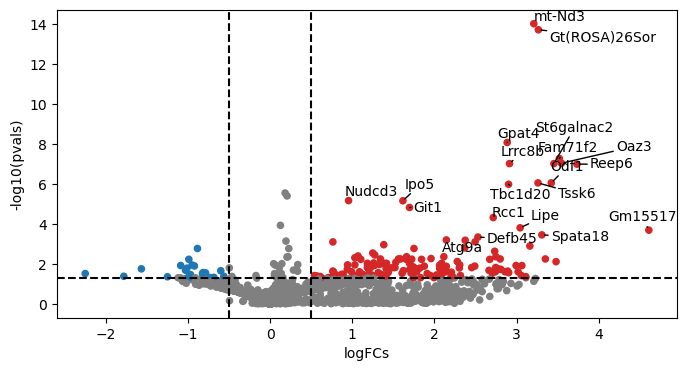

In [57]:
#For all cell types
#cell_type = pdata[pdata.obs['original_cells'] == i].copy()
cell_type = pdata.copy()
genes = dc.filter_by_expr(cell_type, group='condition', min_count=10, min_total_count=15)

# Filter by these genes
cell_type = cell_type[:, genes].copy()
# Build DESeq2 object
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(
    counts=cell_type.X,
    metadata=cell_type.obs,
    design='~condition',
    refit_cooks=True,
    inference=inference,)
# Compute LFCs
dds.deseq2()
# Extract contrast between KO and WT
ds_KO_vs_WT = DeseqStats(
    dds,
    contrast=["condition", 'Knockout', 'WT'],
    inference=inference,
)
# Compute Wald test
ds_KO_vs_WT.summary()
ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")
results_df = ds_KO_vs_WT.results_df
results_df.index = cell_type.var.index

dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)
significant = results_df[abs(results_df['padj']) < 0.05]
singlecell = significant.index
sc_bulk_intersection = list(set(singlecell) & set(bulk['x']))

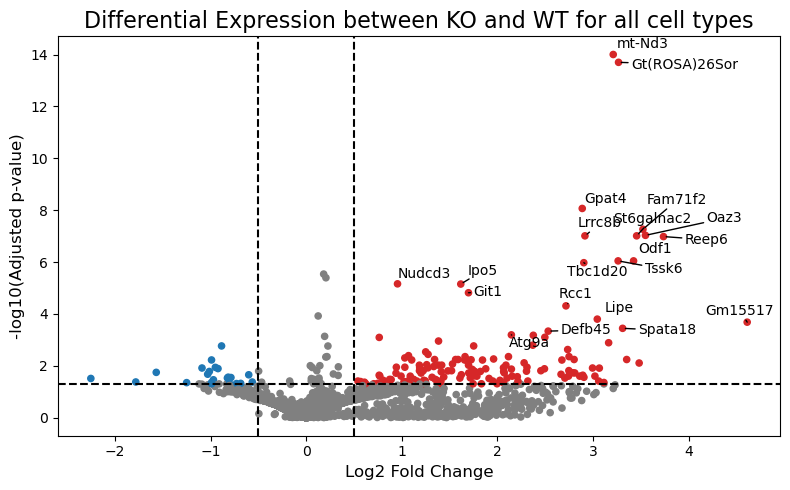

In [58]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 5)
)

plt.title('Differential Expression between KO and WT for all cell types', fontsize=16)
plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('-log10(Adjusted p-value)', fontsize=12)

plt.tight_layout()
plt.savefig('./pseudobulk_DEGs/all_cell_types_all_stages.png', dpi=300)
plt.show()

In [60]:
dict_to_save = {'DEGs_for_all_celltypes': singlecell}
df = pd.DataFrame(dict_to_save)

In [61]:
df.to_csv('./pseudobulk_DEGs/sc_DEGs_for_all_celltypes_all_stages.csv', index=False)

## Check distribution of counts ~condition

In [62]:
for i in set(pdata.obs['joined_clust']):
    cell = pdata[pdata.obs['joined_clust'] == i].copy()
    print('WT, WT, KO, KO sum of counts for ', i )
    print(np.sum(cell.X, axis=1))

#Обычно для ингибирования каунтов больше, но есть типы клеток, где меньше. Вроде как, как раз те, где клетки умирали из-за ингибирования: сперматиды и пр.

WT, WT, KO, KO sum of counts for  Sertoli cells
[ 375205.  313720. 3920622. 7689185.]
WT, WT, KO, KO sum of counts for  Spermatocytes_or_Meiosis_II
[40799512. 47576144. 11502259.   450510.]
WT, WT, KO, KO sum of counts for  Pachytene_or_Diplotene
[11629661.  6714939.]
WT, WT, KO, KO sum of counts for  Early Leydig_or_Sertoli_maybe
[444607. 218306. 781899. 569804.]
WT, WT, KO, KO sum of counts for  Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene
[ 650683.  761314. 2265390. 2418926.]
WT, WT, KO, KO sum of counts for  Leydig cells
[728221. 464441. 768203. 897178.]
WT, WT, KO, KO sum of counts for  T-cells
[131321. 313216.]
WT, WT, KO, KO sum of counts for  Spermatids
[25251918. 29694692.   839680.   121953.]
WT, WT, KO, KO sum of counts for  Macrophages
[179945. 167274. 478179. 470477.]
WT, WT, KO, KO sum of counts for  Fibroblasts
[ 482121.  504130. 3164315. 3663479.]
WT, WT, KO, KO sum of counts for  Pachytene
[2025093. 2018628. 3225004.  851651.]
WT, WT, KO, KO 

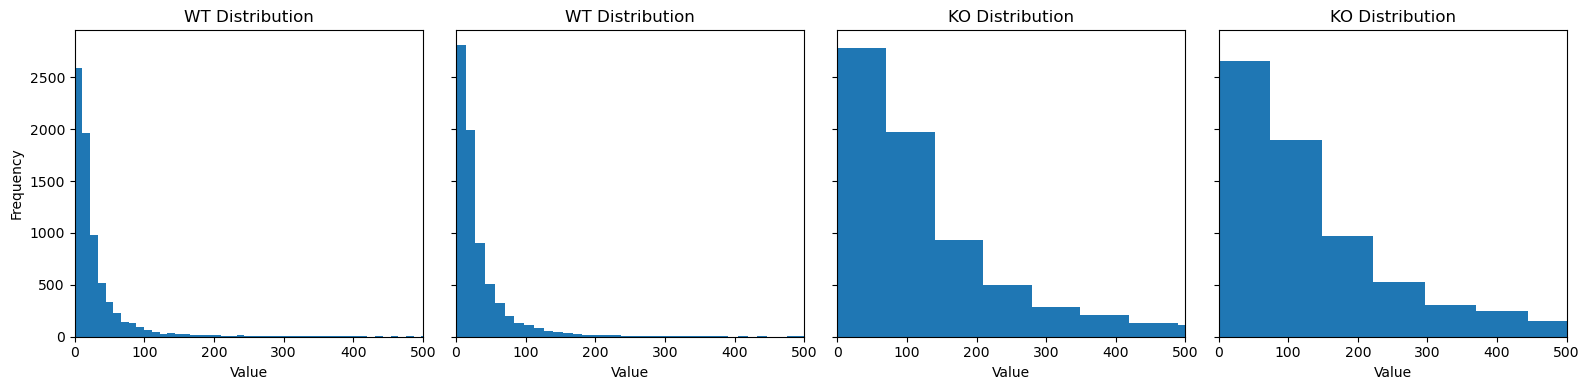

In [64]:
#Get only fibroblasts
fibroblasts = pdata[pdata.obs['joined_clust'] == 'Fibroblasts'].copy()

fibroblasts = fibroblasts[:, genes].copy()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Create a histogram for each row
for i, ax in enumerate(axes):
    ax.hist(fibroblasts.X[i], bins=2000)

    if i == 0 or i == 1:
        ax.set_title(f'WT Distribution')
    else: 
        ax.set_title(f'KO Distribution')
    ax.set_xlabel('Value')
    ax.set_xlim([0, 500])
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

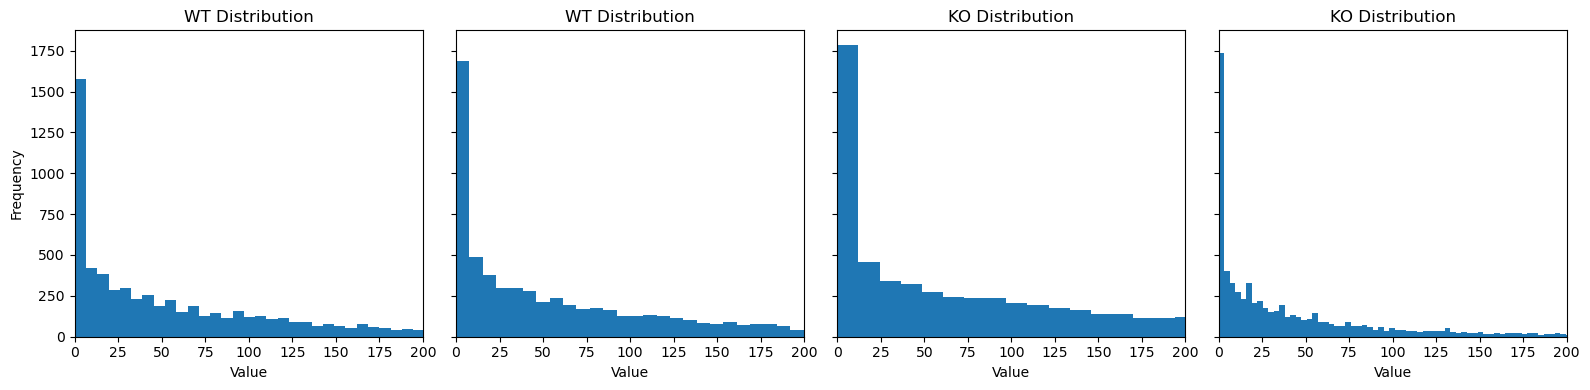

In [68]:
#Get only agranulocytes
pachytene = pdata[pdata.obs['joined_clust'] == 'Pachytene'].copy()

pachytene = pachytene[:, genes].copy()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Create a histogram for each row
for i, ax in enumerate(axes):
    ax.hist(pachytene.X[i], bins=2000)
    if i == 0 or i == 1:
        ax.set_title(f'WT Distribution')
    else: 
        ax.set_title(f'KO Distribution')
    ax.set_xlabel('Value')
    ax.set_xlim([0, 200])
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

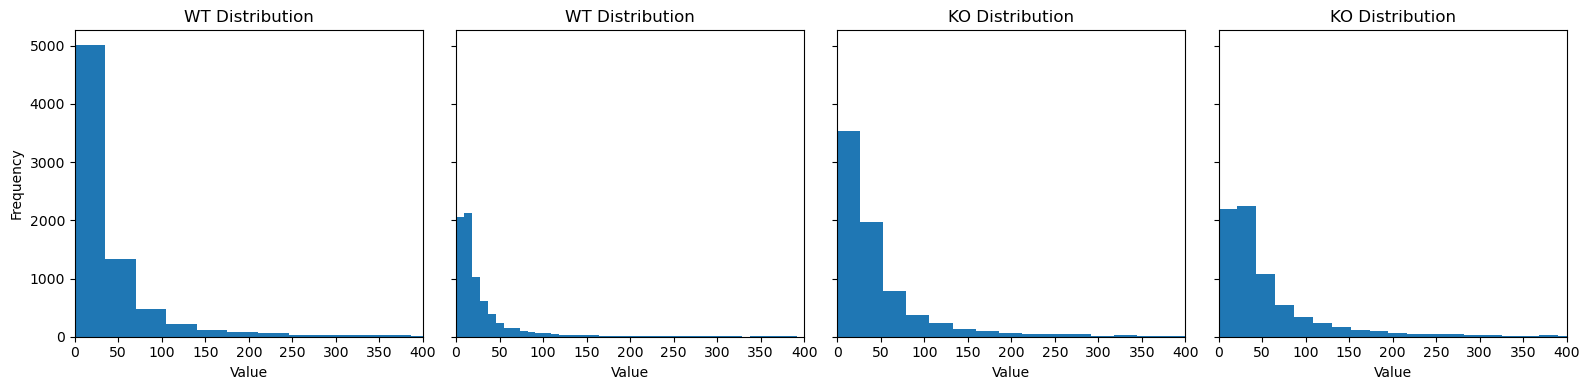

In [67]:
#Get only Leydig cells
leydig = pdata[pdata.obs['joined_clust'] == 'Leydig cells'].copy()
genes = dc.filter_by_expr(leydig, group='condition', min_count=10, min_total_count=15)

# Filter by these genes
leydig = leydig[:, genes].copy()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Create a histogram for each row
for i, ax in enumerate(axes):
    ax.hist(leydig.X[i], bins=2000)
    if i == 0 or i == 1:
        ax.set_title(f'WT Distribution')
    else: 
        ax.set_title(f'KO Distribution')
    ax.set_xlabel('Value')
    ax.set_xlim([0, 400])
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Trying to use mode=mean for pseudobulk DE analysis

In [20]:
import decoupler as dc

# DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [21]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='orig.ident', #== sample
    groups_col='joined_clust', #==cell type
    layer='raw_count',
    mode='mean',
    min_cells=10, #filtration
    min_counts=100 #filtration
)

#Because python doesn't like special symbols
pdata.obs['joined_clust'] = pdata.obs['joined_clust'].astype(str)
pdata.obs.loc[pdata.obs['joined_clust'] == 'Early Leydig/Sertoli cells (?)', 'joined_clust'] = 'Early Leydig_or_Sertoli_maybe'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene', 'joined_clust'] = 'Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Pachytene/Diplotene', 'joined_clust'] = 'Pachytene_or_Diplotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Spermatocytes/Meiosis II', 'joined_clust'] = 'Spermatocytes_or_Meiosis_II'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Undiffentiated/early spermatogonia', 'joined_clust'] = 'Undiffentiated_or_early_spermatogonia'


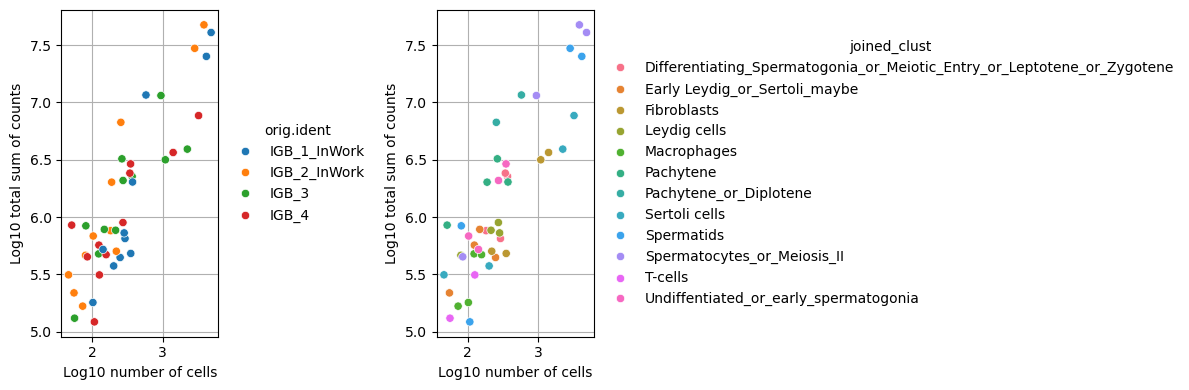

In [25]:
dc.plot_psbulk_samples(pdata, groupby=['orig.ident', 'joined_clust'], figsize=(12, 4))

In [26]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

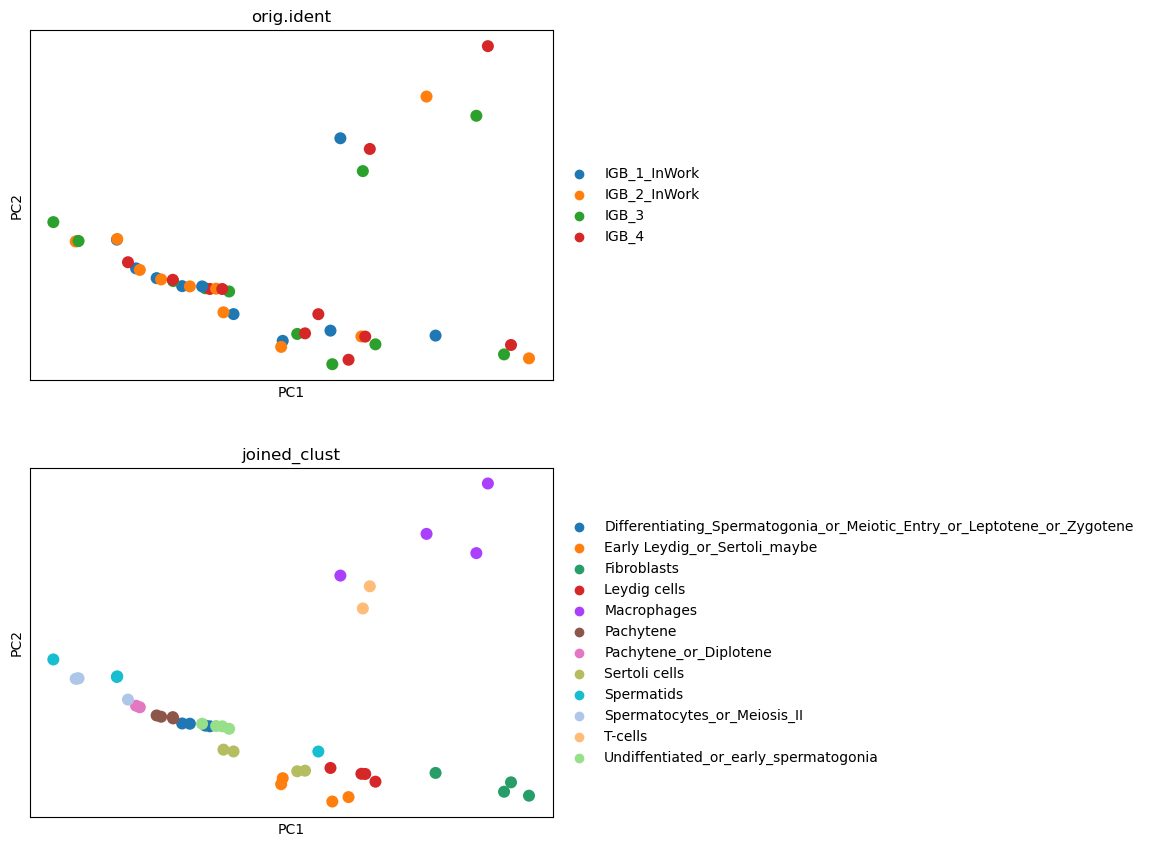

In [27]:
sc.pl.pca(pdata, color=['orig.ident', 'joined_clust'], ncols=1, size=300)
#We see distribution of samples on PCA according to cell types, not samples 

In [28]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['samples', 'condition', 'joined_clust', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

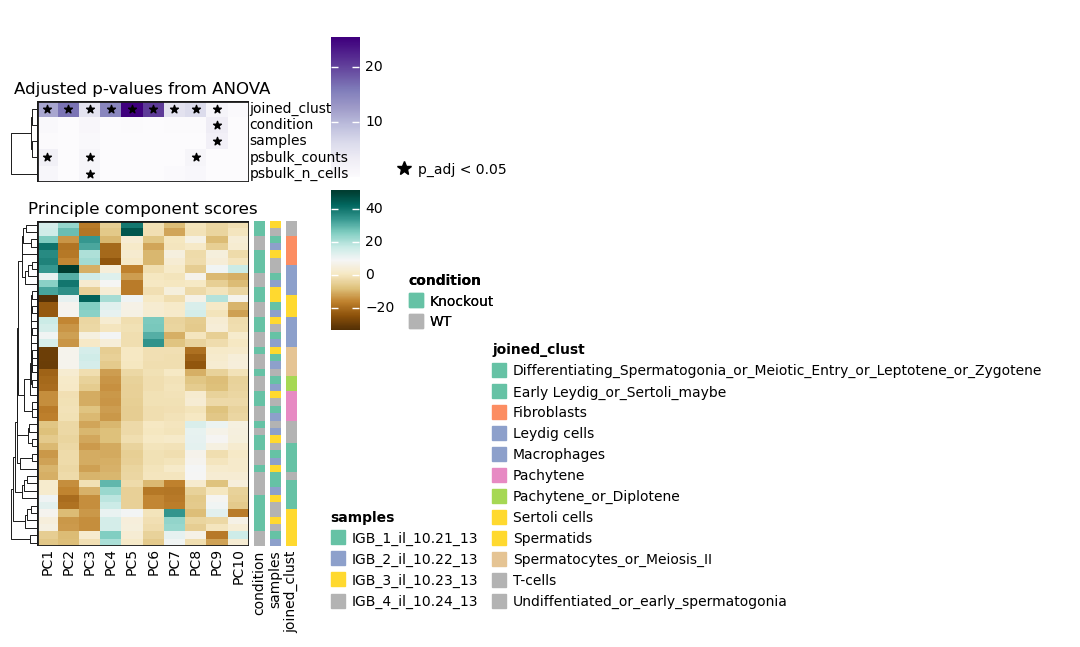

In [29]:
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['condition', 'samples', 'joined_clust'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

#Meaning: PCA separates cell types, not condition

In [30]:
bulk = pd.read_csv('DEGs_from_bulkRNAseq.csv')

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.03 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Using None as control genes, passed at DeseqDataSet initialization


Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...
... done in 0.04 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     7.191546        0.841571  0.881145  0.955089  0.339533  0.950470
1     9.124206       -0.085309  0.798793 -0.106797  0.914950  0.963105
2    24.793904        0.224039  0.562197  0.398506  0.690257  0.950470
3     7.795417       -0.015059  0.835098 -0.018033  0.985612  0.985612
4   169.647220       -0.089474  0.451227 -0.198290  0.842818  0.950470
5    20.117214       -6.800780  1.583834 -4.293871  0.000018  0.000176
6     8.749322       -7.039029  2.478247 -2.840326  0.004507  0.030045
7    15.938521        0.829493  0.654865  1.266662  0.205276  0.821104
8     9.201918        0.412730  0.795423  0.518881  0.603844  0.950470
9    85.318795        0.148278  0.432873  0.342545  0.731941  0.950470
10  134.266229       -0.522559  0.407653 -1.281872  0.199888  0.821104
11   99.448816       -0.077612  0.425962 -0.182203  0.855423  0.950470
12  141.308707

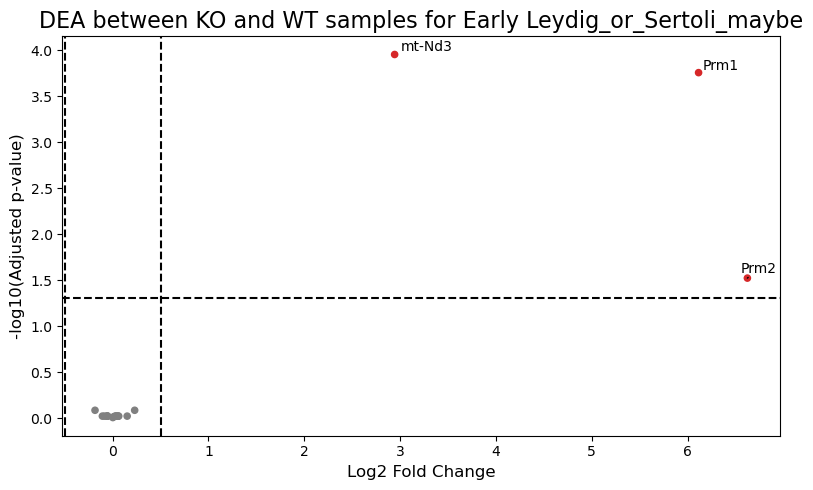

significantly DE genes for  Early Leydig_or_Sertoli_maybe , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.04 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.16 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    8.212384       -0.709628  0.606913 -1.169243  0.242306  0.775397
1    9.598135       -0.174430  0.581069 -0.300188  0.764034  0.899938
2    9.917702       -0.076646  0.573434 -0.133662  0.893670  0.932525
3   18.419419       -1.258505  0.606722 -2.074270  0.038054  0.590108
4   10.457649       -0.027384  0.561246 -0.048791  0.961086  0.977330
5   13.224611       -0.570145  0.514536 -1.108075  0.267829  0.775397
6   19.591470       -0.357577  0.457059 -0.782344  0.434013  0.886749
7   15.134260       -0.563906  0.495803 -1.137358  0.255389  0.775397
8   11.461187       -1.080334  0.549626 -1.965582  0.049347  0.590108
9    8.539202        0.317919  0.615800  0.516269  0.605666  0.899938
10  14.239813        0.555509  0.525838  1.056426  0.290774  0.775397
11   8.241957        0.717791  0.652144  1.100664  0.271043  0.775397
12   9.324376        0.7582

... done in 0.18 seconds.



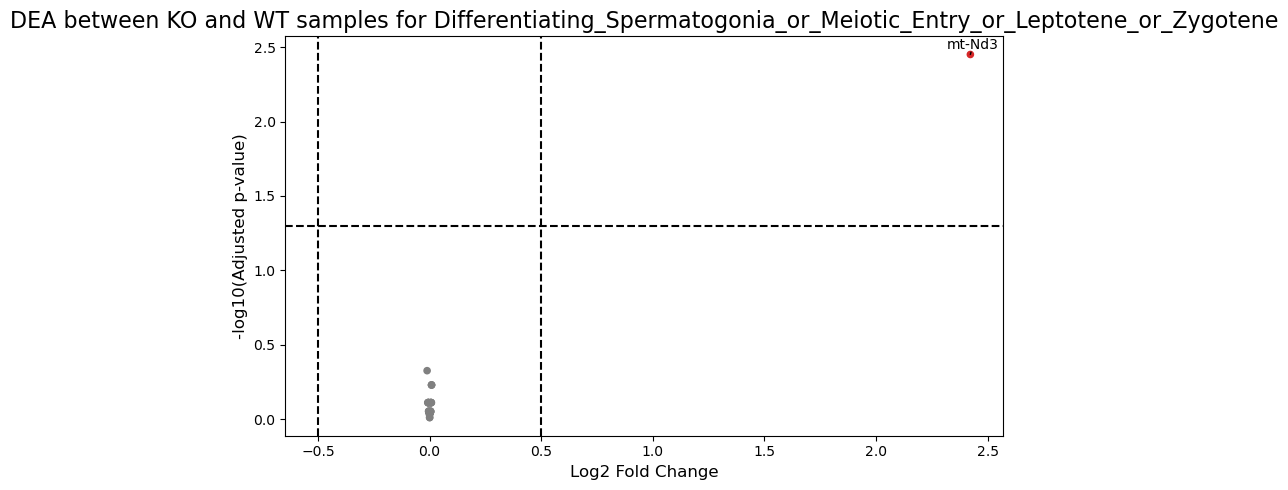

significantly DE genes for  Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.03 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.01 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.06 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     7.500723        1.374129  0.848849  1.618814  0.105487  0.497297
1     6.382590        0.345303  0.782298  0.441395  0.658927  0.869784
2    30.675068       -0.117135  0.533111 -0.219720  0.826090  0.940033
3     7.894502        0.202454  0.728436  0.277929  0.781067  0.920543
4     8.551598       -0.068845  0.701585 -0.098128  0.921831  0.950638
5    45.191402       -1.939307  0.562873 -3.445371  0.000570  0.009410
6    15.150975       -1.344920  0.610681 -2.202327  0.027642  0.182439
7    10.998366       -0.878772  0.649639 -1.352708  0.176149  0.597541
8   112.210320       -1.127531  0.464085 -2.429578  0.015116  0.166281
9    22.343677       -7.161440  1.577031 -4.541088  0.000006  0.000185
10    7.200631        0.631802  0.778779  0.811273  0.417209  0.764883
11    8.564447        0.673353  0.733793  0.917633  0.358811  0.764883
12    6.029582

... done in 0.10 seconds.



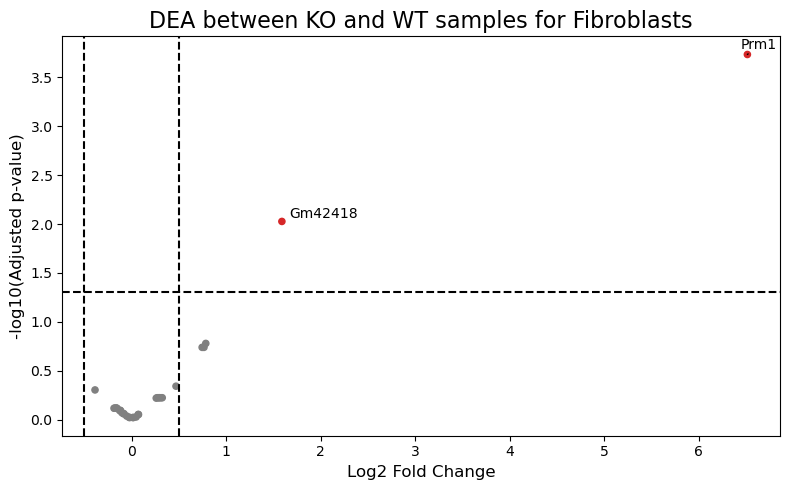

significantly DE genes for  Fibroblasts , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.11 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.03 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.06 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...


There is no KO or WT samples for this cell type
Using None as control genes, passed at DeseqDataSet initialization


... done in 0.13 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.18 seconds.

Fitting LFCs...
... done in 0.07 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.03 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   10.106955       -0.218298  0.627245 -0.348026  0.727820  0.995475
1   10.720414       -0.189491  0.617039 -0.307097  0.758769  0.995475
2   11.431673       -0.354291  0.606133 -0.584510  0.558877  0.995475
3   12.928359       -0.169017  0.583766 -0.289529  0.772176  0.995475
4    8.901254       -0.278287  0.646483 -0.430463  0.666859  0.995475
..        ...             ...       ...       ...       ...       ...
84  22.893739       -0.241689  0.512324 -0.471752  0.637104  0.995475
85  15.621569       -0.156011  0.556369 -0.280410  0.779163  0.995475
86   9.063336       -2.602237  0.754482 -3.449039  0.000563  0.050070
87  18.853793       -0.231743  0.532679 -0.435052  0.663524  0.995475
88  13.095077        0.120545  0.586199  0.205639  0.837073  0.995475

[89 rows x 6 columns]


Fitting MAP LFCs...
... done in 0.39 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   10.106955    5.746433e-07  0.001354 -0.348026  0.727820  0.995475
1   10.720414    5.174238e-07  0.001356 -0.307097  0.758769  0.995475
2   11.431673    9.969067e-07  0.001375 -0.584510  0.558877  0.995475
3   12.928359    5.189351e-07  0.001367 -0.289529  0.772176  0.995475
4    8.901254    6.926379e-07  0.001359 -0.430463  0.666859  0.995475
..        ...             ...       ...       ...       ...       ...
84  22.893739    9.217689e-07  0.001405 -0.471752  0.637104  0.995475
85  15.621569    5.272976e-07  0.001373 -0.280410  0.779163  0.995475
86   9.063336    2.079536e+00  0.756909 -3.449039  0.000563  0.050070
87  18.853793    8.743511e-07  0.001392 -0.435052  0.663524  0.995475
88  13.095077   -3.627233e-07  0.001336  0.205639  0.837073  0.995475

[89 rows x 6 columns]


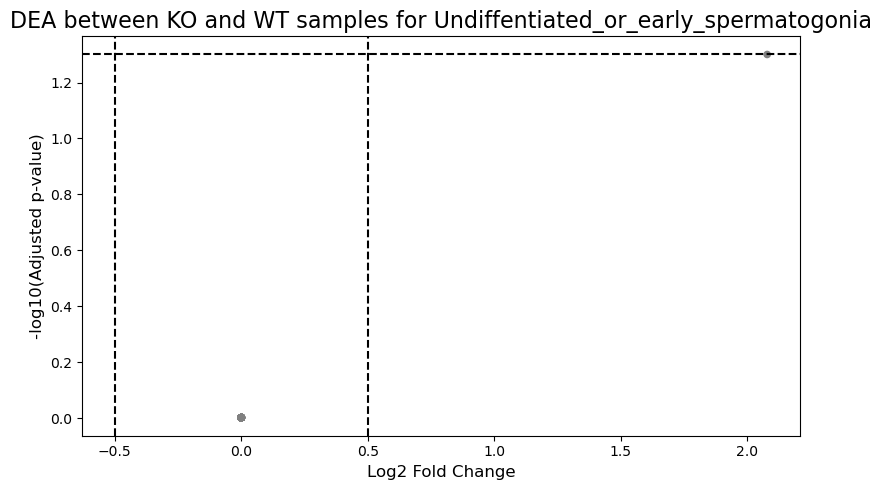

significantly DE genes for  Undiffentiated_or_early_spermatogonia , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.15 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.30 seconds.

Fitting LFCs...
... done in 0.12 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.04 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     9.337915        0.022985  0.771913  0.029777  0.976245  0.992602
1     8.473758       -0.077277  0.818709 -0.094389  0.924800  0.992602
2    11.071655       -0.137981  0.711531 -0.193921  0.846237  0.992602
3    12.107771        0.288753  0.678859  0.425351  0.670581  0.992602
4    12.987773        0.434464  0.656060  0.662233  0.507822  0.992602
..         ...             ...       ...       ...       ...       ...
145  22.937918       -0.128359  0.497340 -0.258090  0.796337  0.992602
146   9.489087        0.217699  0.787806  0.276335  0.782291  0.992602
147  15.094504       -0.121229  0.618479 -0.196011  0.844601  0.992602
148  11.495303       -0.045052  0.710280 -0.063428  0.949426  0.992602
149  13.341713        0.253353  0.671037  0.377554  0.705762  0.992602

[150 rows x 6 columns]


Fitting MAP LFCs...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
... done in 0.70 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     9.337915   -3.626587e-08  0.001477  0.029777  0.976245  0.992602
1     8.473758    1.216364e-07  0.001474 -0.094389  0.924800  0.992602
2    11.071655    2.863828e-07  0.001501 -0.193921  0.846237  0.992602
3    12.107771   -6.588830e-07  0.001432  0.425351  0.670581  0.992602
4    12.987773   -1.046199e-06  0.001410  0.662233  0.507822  0.992602
..         ...             ...       ...       ...       ...       ...
145  22.937918    5.450001e-07  0.001500 -0.258090  0.796337  0.992602
146   9.489087   -3.660397e-07  0.001456  0.276335  0.782291  0.992602
147  15.094504    3.324261e-07  0.001506 -0.196011  0.844601  0.992602
148  11.495303    9.997035e-08  0.001495 -0.063428  0.949426  0.992602
149  13.341713   -5.185892e-07  0.001447  0.377554  0.705762  0.992602

[150 rows x 6 columns]


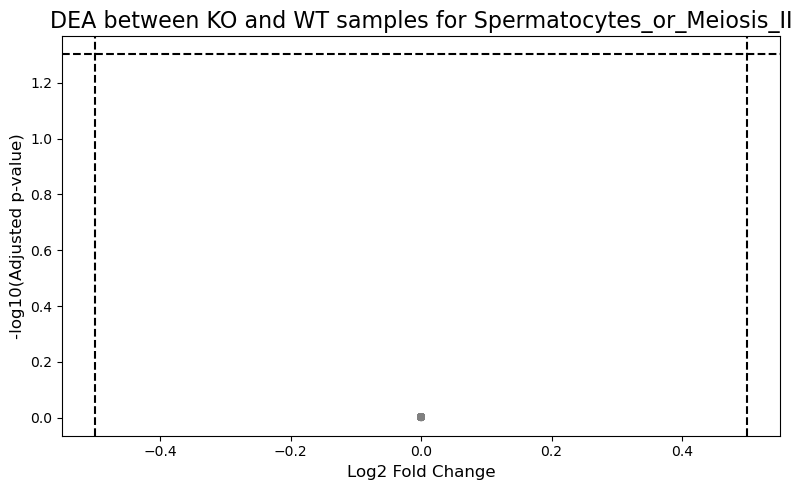

significantly DE genes for  Spermatocytes_or_Meiosis_II , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.16 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.32 seconds.

Fitting LFCs...
... done in 0.15 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.06 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.085234        0.180261  0.668699  0.269570  0.787491  0.994438
1    11.823314        0.222149  0.662018  0.335564  0.737200  0.994438
2    16.953201       -0.129092  0.616728 -0.209318  0.834200  0.994438
3     9.443930        0.024983  0.697943  0.035795  0.971446  0.994438
4     9.033663       -0.735486  0.718402 -1.023781  0.305939  0.994438
..         ...             ...       ...       ...       ...       ...
168  20.699614        0.192030  0.589880  0.325542  0.744771  0.994438
169  22.756377        0.070673  0.590343  0.119715  0.904709  0.994438
170  10.591342       -2.666488  0.768678 -3.468928  0.000523  0.090399
171  22.962086        0.027496  0.577891  0.047580  0.962051  0.994438
172  16.883063        0.371888  0.617230  0.602511  0.546834  0.994438

[173 rows x 6 columns]


... done in 0.72 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.085234   -4.202402e-07  0.001331  0.269570  0.787491  0.994438
1    11.823314   -5.289058e-07  0.001330  0.335564  0.737200  0.994438
2    16.953201    3.540612e-07  0.001383 -0.209318  0.834200  0.994438
3     9.443930   -6.555341e-08  0.001341  0.035795  0.971446  0.994438
4     9.033663    1.452790e-06  0.001420 -1.023781  0.305939  0.994438
..         ...             ...       ...       ...       ...       ...
168  20.699614   -5.731269e-07  0.001349  0.325542  0.744771  0.994438
169  22.756377   -2.073540e-07  0.001369  0.119715  0.904709  0.994438
170  10.591342    2.128702e+00  0.783222 -3.468928  0.000523  0.090399
171  22.962086   -9.482098e-08  0.001375  0.047580  0.962051  0.994438
172  16.883063   -1.006421e-06  0.001318  0.602511  0.546834  0.994438

[173 rows x 6 columns]


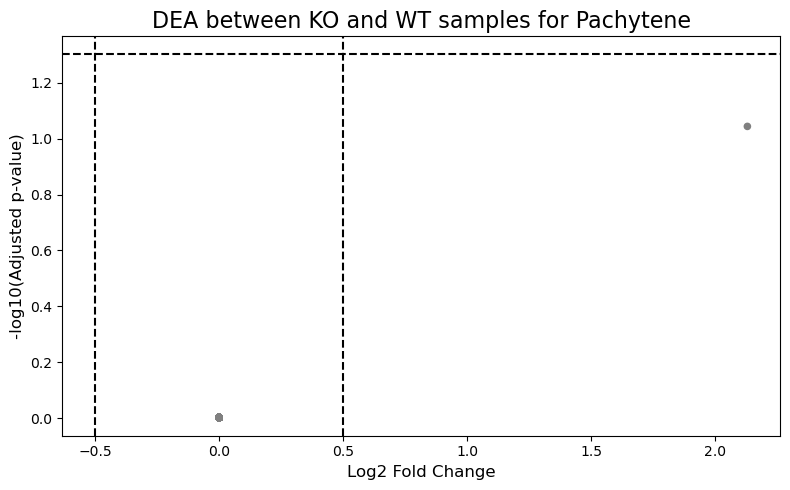

significantly DE genes for  Pachytene , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.04 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.02 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    10.314085        0.475256  0.734445  0.647096  0.517570  0.935867
1    15.338830        0.110918  0.710274  0.156162  0.875905  0.981989
2    14.232535        1.033604  0.733985  1.408208  0.159070  0.600930
3    10.065504        0.016482  0.730068  0.022576  0.981989  0.981989
4    11.182367       -0.823953  0.734946 -1.121108  0.262242  0.881495
5     8.877396       -3.866506  1.197571 -3.228625  0.001244  0.021146
6    18.950441       -0.679825  0.708132 -0.960025  0.337042  0.881495
7     9.847346        0.516198  0.756263  0.682564  0.494882  0.935867
8    31.634105        0.304108  0.677965  0.448560  0.653749  0.963593
9    16.199599        0.975291  0.674718  1.445479  0.148323  0.600930
10   11.777193        1.964130  0.769255  2.553288  0.010671  0.090705
11    8.975442       -2.805342  0.973695 -2.881128  0.003963  0.044909
12  225.064069

... done in 0.08 seconds.



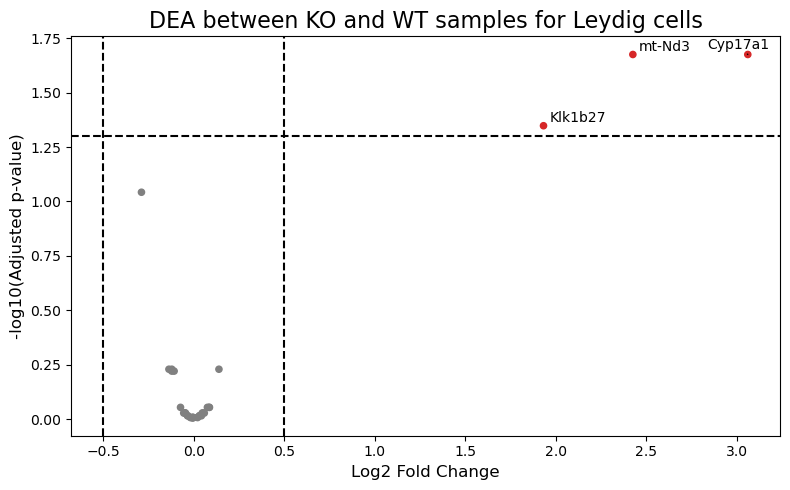

significantly DE genes for  Leydig cells , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.01 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   15.991813        0.494481  0.741509  0.666858  0.504863  0.673151
1   17.273909        1.675505  0.734760  2.280345  0.022587  0.090349
2   54.206953        0.361678  0.682981  0.529558  0.596419  0.745523
3   12.488924        1.105570  0.771612  1.432805  0.151914  0.379784
4   22.615174        0.898089  0.966860  0.928872  0.352956  0.588259
5   26.258293       -5.765011  1.596260 -3.611573  0.000304  0.006087
6   10.312560       -5.906954  2.492151 -2.370223  0.017777  0.090349
7   13.380209        0.859698  0.786180  1.093513  0.274169  0.517430
8   14.934078        0.854462  0.798508  1.070073  0.284586  0.517430
9   16.195459        2.687655  0.800570  3.357176  0.000787  0.007874
10   6.500067       -5.215456  2.491861 -2.092996  0.036350  0.121165
11  30.757527       -0.152073  0.675617 -0.225087  0.821911  0.865170
12  57.171072       -0.9149

Fitting MAP LFCs...
... done in 0.05 seconds.



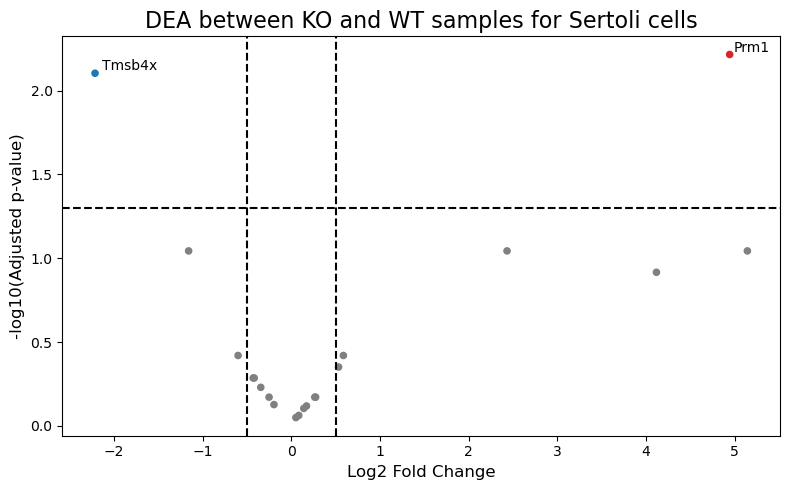

significantly DE genes for  Sertoli cells , intersected with bulk DEGs:
['Tmsb4x']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.22 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.18 seconds.

Fitting LFCs...
... done in 0.19 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.03 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.421137       -0.602079  1.352919 -0.445022  0.656304  0.969801
1    10.388078       -1.514854  1.343650 -1.127417  0.259566  0.930283
2     7.577529       -1.349438  1.362798 -0.990197  0.322078  0.930283
3     7.549149       -0.900717  1.356103 -0.664195  0.506566  0.936631
4    27.676918       -1.904456  1.335228 -1.426315  0.153778  0.930283
..         ...             ...       ...       ...       ...       ...
97   15.647651       -0.203119  1.196167 -0.169808  0.865161  0.969801
98   11.859002        1.584343  1.216883  1.301968  0.192927  0.930283
99    6.036748       -1.661980  1.406590 -1.181567  0.237377  0.930283
100   3.937340       -1.833318  1.488255 -1.231857  0.218002  0.930283
101   5.658215       -0.652552  1.385259 -0.471069  0.637592  0.969801

[102 rows x 6 columns]


... done in 0.52 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.421137    3.635995e-07  0.001619 -0.445022  0.656304  0.969801
1    10.388078    8.883179e-07  0.001952 -1.127417  0.259566  0.930283
2     7.577529    7.837085e-07  0.001880 -0.990197  0.322078  0.930283
3     7.549149    5.703195e-07  0.001719 -0.664195  0.506566  0.936631
4    27.676918    1.010234e-06  0.002179 -1.426315  0.153778  0.930283
..         ...             ...       ...       ...       ...       ...
97   15.647651    1.565063e-07  0.001520 -0.169808  0.865161  0.969801
98   11.859002   -1.038482e-06  0.001242  1.301968  0.192927  0.930283
99    6.036748    8.975582e-07  0.001994 -1.181567  0.237377  0.930283
100   3.937340    8.154231e-07  0.002028 -1.231857  0.218002  0.930283
101   5.658215    3.806526e-07  0.001645 -0.471069  0.637592  0.969801

[102 rows x 6 columns]


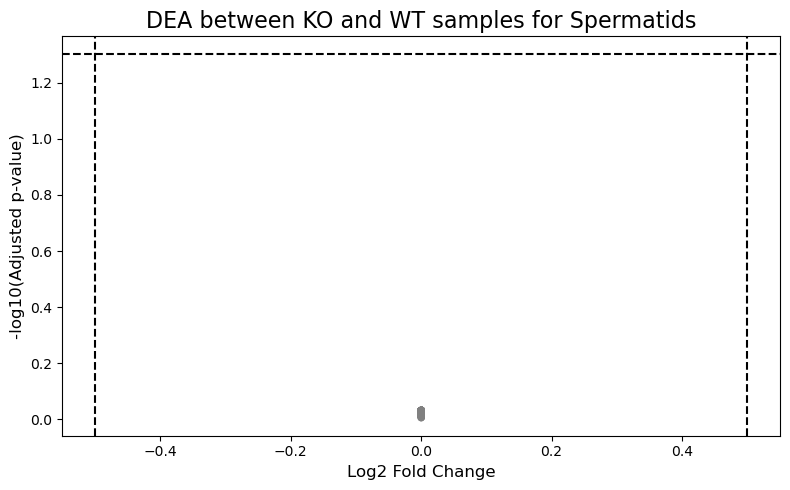

significantly DE genes for  Spermatids , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.45 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.03 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.64 seconds.

Fitting LFCs...
... done in 0.31 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.04 seconds.

Fitting 

There is no KO or WT samples for this cell type
Using None as control genes, passed at DeseqDataSet initialization


... done in 0.06 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   19.238080        0.618937  1.135701  0.544982  0.585766  0.993457
1   41.061636       -0.553611  1.045335 -0.529602  0.596388  0.993457
2    8.447684        0.060456  1.160146  0.052111  0.958441  0.993457
3    7.029214        0.199632  1.213947  0.164449  0.869378  0.993457
4   10.853757       -0.038774  1.132253 -0.034245  0.972682  0.993457
5   15.507408        0.159947  1.100900  0.145288  0.884484  0.993457
6   16.412229        0.307570  1.107647  0.277679  0.781259  0.993457
7   15.291974        0.196265  1.104748  0.177656  0.858993  0.993457
8   20.833425       -0.211159  1.176871 -0.179424  0.857605  0.993457
9    8.186480       -0.024606  1.164715 -0.021127  0.983145  0.993457
10  13.725023       -0.202073  1.121557 -0.180172  0.857017  0.993457
11  40.106526       -0.295775  1.053097 -0.280862  0.778816  0.993457
12  30.114247       -7.3472

... done in 0.14 seconds.



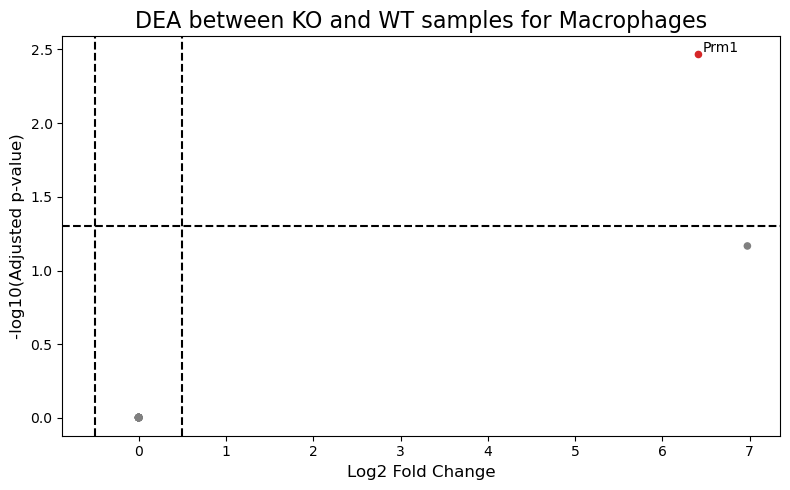

significantly DE genes for  Macrophages , intersected with bulk DEGs:
[]


In [34]:
for i in set(pdata.obs['joined_clust']):
    cell_type = pdata[pdata.obs['joined_clust'] == i].copy()
    genes = dc.filter_by_expr(cell_type, group='condition', min_count=10, min_total_count=15)

    # Filter by these genes
    cell_type = cell_type[:, genes].copy()
    cell_type.X = cell_type.X.round().astype(int)
    # Build DESeq2 object
    inference = DefaultInference(n_cpus=1)
    dds = DeseqDataSet(
        counts=cell_type.X,
        metadata=cell_type.obs,
        design='~condition',
        refit_cooks=True,
        inference=inference,
    )
    # Compute LFCs
    dds.deseq2()

    if 'Knockout' not in set(dds.obs['condition']) or 'WT' not in set(dds.obs['condition']):
        print('There is no KO or WT samples for this cell type')
        continue
    
    # Extract contrast between KO and WT
    ds_KO_vs_WT = DeseqStats(
        dds,
        contrast=["condition", 'Knockout', 'WT'],
        inference=inference,
    )
    # Compute Wald test
    ds_KO_vs_WT.summary()
    ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")
    results_df = ds_KO_vs_WT.results_df
    results_df.index = cell_type.var.index

    dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=20,
        figsize=(8, 5)
    )

    title = 'DEA between KO and WT samples for ' + i
    plt.title(title, fontsize=16)
    plt.xlabel('Log2 Fold Change', fontsize=12)
    plt.ylabel('-log10(Adjusted p-value)', fontsize=12)
    
    plt.tight_layout()
    path = f'./pseudobulk_DEGs/mean_mode_all_stages{i}.png'
    plt.savefig(path, dpi=300)
    plt.show()

    
    significant = results_df[abs(results_df['padj']) < 0.05]
    singlecell = significant.index
    sc_bulk_intersection = list(set(singlecell) & set(bulk['x']))

    print('significantly DE genes for ', i, ', intersected with bulk DEGs:')
    print(sc_bulk_intersection)
    
    dict_to_save = {i: sc_bulk_intersection}
    df = pd.DataFrame(dict_to_save)
    path = './pseudobulk_DEGs/sc_bulk_intersected_DEGs_for_mean_mode_all_stages'+i+'.csv'
    df.to_csv(path, index=False)

    dict_to_save = {i: singlecell}
    df = pd.DataFrame(dict_to_save)
    path = './pseudobulk_DEGs/sc_DEGs_for_mean_mode_all_stages'+i+'.csv'
    df.to_csv(path, index=False)